# Part 3.2: Optimization & Linear Programming

Every machine learning algorithm is, at its core, an optimization problem. When we train a neural network, we are searching for the set of weights that minimizes a loss function. When we fit a support vector machine, we are solving a constrained quadratic program. When we tune hyperparameters, we are optimizing a noisy black-box function.

But here is the thing: **F1 teams were doing optimization long before it was cool in ML**. Every race weekend, teams solve dozens of optimization problems — how much fuel to load, when to pit, which tire compound to fit, how to set the suspension, how to split the budget across development areas. All of it subject to strict FIA regulations (constraints) with the goal of minimizing race time (the objective function).

Understanding optimization gives you the vocabulary and intuition to answer questions like:
- *Why does gradient descent work?* (Because loss functions are often convex, or at least locally convex.)
- *Why does regularization help?* (It adds a constraint to the optimization, shrinking the feasible region.)
- *Why do SVMs find the "best" boundary?* (They solve a convex optimization problem with a unique global solution.)
- *Why does an F1 strategist pick lap 22 for the pit stop instead of lap 18?* (Because it sits at the optimal vertex of their strategy polytope.)

This notebook builds the mathematical foundation you need before diving into gradient-based methods in the next notebook.

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Define an optimization problem (objective, constraints, feasible region)
- [ ] Formulate and solve linear programs graphically and with `scipy`
- [ ] Explain the Simplex method at a conceptual level
- [ ] State weak and strong duality and explain their significance
- [ ] Distinguish convex from non-convex problems and explain why convexity matters
- [ ] Apply Lagrange multipliers to equality-constrained problems
- [ ] State the KKT conditions and explain their role in inequality constraints
- [ ] Recognize ML algorithms as optimization problems (SVM, regularized regression)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog, minimize
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

## 1. What is Optimization?

### Intuitive Explanation

Optimization is the art and science of finding the **best** solution from a set of possible solutions. In everyday life, you optimize constantly:
- Choosing the fastest route to work (minimize travel time)
- Allocating a budget across expenses (maximize value subject to spending limits)
- Setting a thermostat (minimize energy use while staying comfortable)

### The F1 Connection

An F1 strategist faces optimization problems every single session. Should we run the medium or hard compound in the second stint? How much fuel do we load for qualifying? What rear wing angle balances top speed against cornering downforce? Every decision is a trade-off, every regulation is a constraint, and the clock is always the objective function.

In mathematics, an optimization problem has three parts:

1. **Objective function** $f(x)$: The quantity we want to minimize (or maximize) — in F1, this is race time or total points scored
2. **Decision variables** $x$: The knobs we can turn — pit stop laps, fuel load, tire compound selection, wing angle
3. **Constraints**: Rules that limit which values of $x$ are allowed — FIA regulations like fuel flow limits, minimum weight, tire allocations, budget cap

The general form is:

$$\min_{x} f(x) \quad \text{subject to} \quad g_i(x) \leq 0, \quad h_j(x) = 0$$

The set of all $x$ that satisfy the constraints is called the **feasible region** — every legal strategy combination. The best point within the feasible region is the **optimal solution** — the strategy the team actually runs.

**What this means:** Think of the objective function as a landscape of hills and valleys. The constraints fence off a region you are allowed to explore. Your job is to find the lowest valley (for minimization) inside the fence. In F1 terms, the landscape is "race time as a function of all setup and strategy variables," the fence is "FIA regulations," and the lowest valley is "the fastest legal strategy."

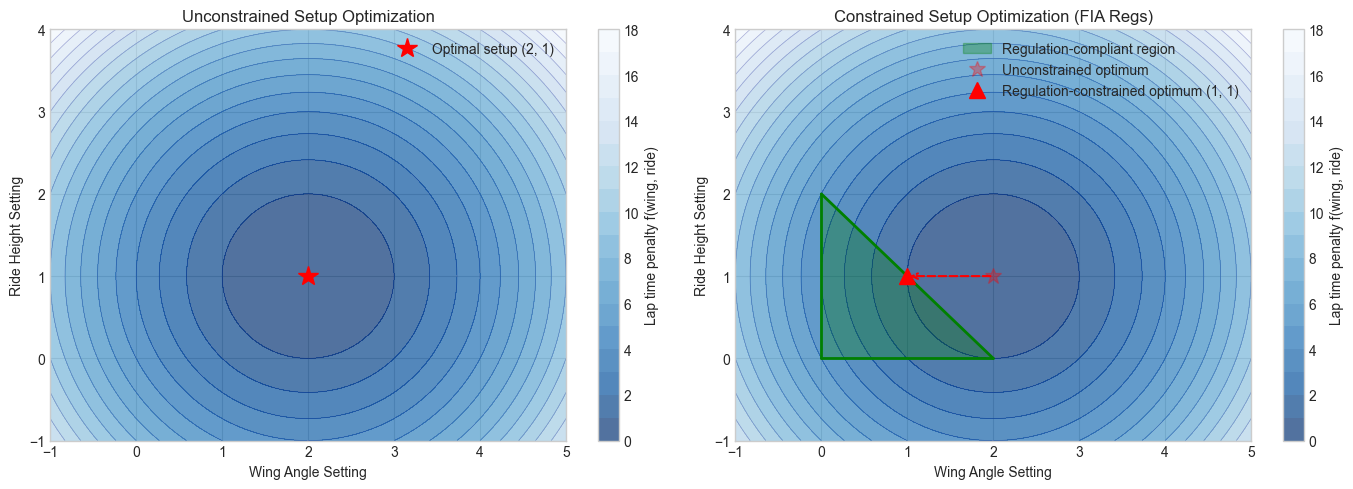

Left: Without regulations, the optimal setup is at (2, 1) where penalty = 0.
Right: With the regulation wing + ride <= 2 (and both >= 0),
       the optimum shifts to (1, 1) on the regulation boundary, where penalty = 1.
       This is exactly what happens when FIA floor rules force teams off their ideal setup.


In [2]:
# Visualize a simple 2D optimization landscape
# F1 analogy: finding the optimal car setup (wing angle vs ride height)
def setup_performance(wing_angle, ride_height):
    """Lap time penalty as a function of setup: f(wing, ride) = (wing - 2)^2 + (ride - 1)^2"""
    return (wing_angle - 2)**2 + (ride_height - 1)**2

wing_angle = np.linspace(-1, 5, 300)
ride_height = np.linspace(-1, 4, 300)
WING, RIDE = np.meshgrid(wing_angle, ride_height)
Z = setup_performance(WING, RIDE)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: contour plot — unconstrained setup optimization
ax = axes[0]
contour = ax.contourf(WING, RIDE, Z, levels=20, cmap='Blues_r', alpha=0.7)
ax.contour(WING, RIDE, Z, levels=20, colors='navy', alpha=0.3, linewidths=0.5)
ax.plot(2, 1, 'r*', markersize=15, label='Optimal setup (2, 1)')
plt.colorbar(contour, ax=ax, label='Lap time penalty f(wing, ride)')
ax.set_xlabel('Wing Angle Setting')
ax.set_ylabel('Ride Height Setting')
ax.set_title('Unconstrained Setup Optimization')
ax.legend()

# Right: same landscape with FIA regulation constraints
ax = axes[1]
contour = ax.contourf(WING, RIDE, Z, levels=20, cmap='Blues_r', alpha=0.7)
ax.contour(WING, RIDE, Z, levels=20, colors='navy', alpha=0.3, linewidths=0.5)

# Constraint: wing + ride <= 2 (regulatory floor/aero limit) and both >= 0
feasible_vertices = np.array([[0, 0], [2, 0], [0, 2]])
feasible_region = Polygon(feasible_vertices, alpha=0.3, color='green', label='Regulation-compliant region')
ax.add_patch(feasible_region)
ax.plot([0, 2], [2, 0], 'g-', linewidth=2)
ax.plot([0, 0], [0, 2], 'g-', linewidth=2)
ax.plot([0, 2], [0, 0], 'g-', linewidth=2)

# The constrained optimum is at (1, 1) — closest feasible point to (2,1)
ax.plot(2, 1, 'r*', markersize=12, alpha=0.3, label='Unconstrained optimum')
ax.plot(1, 1, 'r^', markersize=12, label='Regulation-constrained optimum (1, 1)')
ax.annotate('', xy=(1, 1), xytext=(2, 1),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5, ls='--'))
plt.colorbar(contour, ax=ax, label='Lap time penalty f(wing, ride)')
ax.set_xlabel('Wing Angle Setting')
ax.set_ylabel('Ride Height Setting')
ax.set_title('Constrained Setup Optimization (FIA Regs)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Left: Without regulations, the optimal setup is at (2, 1) where penalty = 0.")
print("Right: With the regulation wing + ride <= 2 (and both >= 0),")
print("       the optimum shifts to (1, 1) on the regulation boundary, where penalty = 1.")
print("       This is exactly what happens when FIA floor rules force teams off their ideal setup.")

### Deep Dive: Types of Optimization Problems

Optimization problems are classified by the nature of their objective and constraints:

| Type | Objective | Constraints | Example in ML | F1 Parallel |
|------|-----------|-------------|---------------|-------------|
| **Linear Programming (LP)** | Linear | Linear inequalities/equalities | Resource allocation, network flow | Fuel/tire strategy under FIA regs |
| **Quadratic Programming (QP)** | Quadratic | Linear | SVM (dual form), ridge regression | Aero balance optimization |
| **Convex Optimization** | Convex | Convex set | Logistic regression, LASSO | Car setup tuning (smooth landscape) |
| **Non-convex Optimization** | Non-convex | Any | Neural network training | Full car design (aero + engine + chassis) |
| **Integer Programming** | Linear/Quadratic | Integer variables | Feature selection | Number of pit stops (1, 2, or 3) |

#### Key Insight

The difficulty of an optimization problem depends on its **structure**, not its size. A convex problem with a million variables is easier (in principle) than a non-convex problem with ten variables. This is why understanding convexity matters so much in ML — and why F1 engineers decompose the car design problem into simpler convex sub-problems whenever they can.

---

## 2. Linear Programming

### Intuitive Explanation

A **linear program (LP)** is the simplest type of optimization problem: both the objective function and all constraints are linear.

**Standard form:**

$$\min_{x} \mathbf{c}^T \mathbf{x} \quad \text{subject to} \quad A\mathbf{x} \leq \mathbf{b}, \quad \mathbf{x} \geq 0$$

#### Breaking down the formula:

| Component | Meaning | Role | F1 Parallel |
|-----------|---------|------|-------------|
| $\mathbf{c}^T \mathbf{x}$ | Dot product of cost vector and decision variables | Objective to minimize | Race time as a function of strategy choices |
| $A\mathbf{x} \leq \mathbf{b}$ | Matrix inequality | Constraint on resources | FIA regulations (fuel flow, weight, budget) |
| $\mathbf{x} \geq 0$ | Non-negativity | Variables must be non-negative | Can't have negative fuel or negative pit stops |

### The F1 Connection

Imagine you are an F1 race strategist deciding how to allocate two limited resources — **tire sets** and **pit crew time** — across stint planning. Each strategy option gives a different time advantage (the objective). Each strategy uses different amounts of your limited resources (the constraints). How do you plan the race to minimize total time?

### Geometric Intuition

The feasible region of an LP is always a **convex polytope** (a polygon in 2D, a polyhedron in 3D, etc.). The objective function creates parallel hyperplanes across the space. The optimal solution always occurs at a **vertex** of the polytope.

Why a vertex? Because a linear function over a convex region achieves its extreme values at the boundary, and specifically at a corner point. In F1 terms, the best strategy is always at a "corner" of the regulation space — you are always pushing against at least one regulation limit.

/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/393201854.py:64: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/393201854.py:64: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


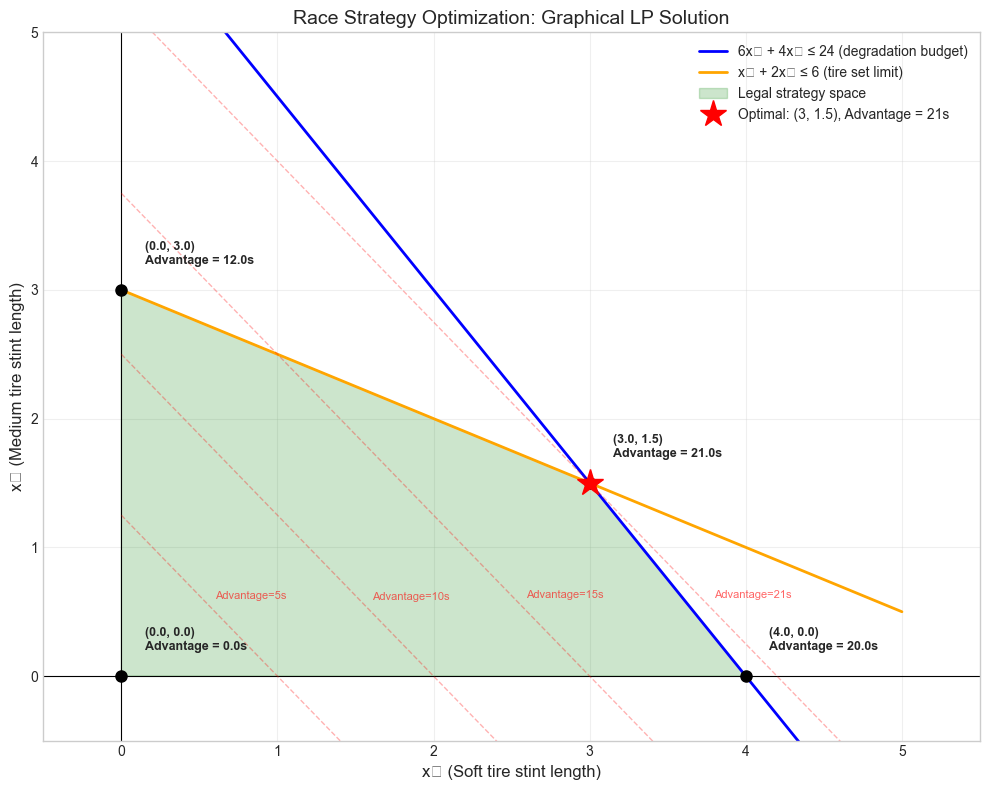

The optimal strategy is at vertex (3, 1.5) with a time advantage of 21 seconds.
Notice: the optimum is at a vertex of the feasible polytope — this always
happens for linear programs. The best race strategy pushes against regulation limits.


In [3]:
# Example LP: F1 Race Strategy Optimization
# A team must decide how many laps to run on soft tires (x1) vs medium tires (x2)
# Maximize: 5*x1 + 4*x2 (time advantage in seconds — softs are faster per lap)
# Subject to:
#   6*x1 + 4*x2 <= 24  (tire degradation budget — softs degrade faster)
#   x1 + 2*x2 <= 6     (available tire sets)
#   x1, x2 >= 0

# Graphical solution
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 5, 400)

# Constraint boundaries
y1 = (24 - 6*x) / 4   # 6x1 + 4x2 = 24 (degradation budget)
y2 = (6 - x) / 2       # x1 + 2x2 = 6 (tire set limit)

# Plot constraints
ax.plot(x, y1, 'b-', linewidth=2, label='6x₁ + 4x₂ ≤ 24 (degradation budget)')
ax.plot(x, y2, 'orange', linewidth=2, label='x₁ + 2x₂ ≤ 6 (tire set limit)')
ax.axhline(y=0, color='k', linewidth=0.8)
ax.axvline(x=0, color='k', linewidth=0.8)

# Feasible region vertices (found by solving intersection equations)
vertices = np.array([
    [0, 0],
    [4, 0],    # x1=4, x2=0: max soft stint, no mediums
    [3, 1.5],  # intersection of both constraints
    [0, 3],    # x1=0, x2=3: all mediums
])

# Fill feasible region
feasible = Polygon(vertices, alpha=0.2, color='green', label='Legal strategy space')
ax.add_patch(feasible)

# Mark vertices
for v in vertices:
    time_advantage = 5*v[0] + 4*v[1]
    ax.plot(v[0], v[1], 'ko', markersize=8)
    ax.annotate(f'({v[0]:.1f}, {v[1]:.1f})\nAdvantage = {time_advantage:.1f}s',
                xy=(v[0], v[1]), xytext=(v[0]+0.15, v[1]+0.2),
                fontsize=9, fontweight='bold')

# Optimal vertex
ax.plot(3, 1.5, 'r*', markersize=20, zorder=5, label='Optimal: (3, 1.5), Advantage = 21s')

# Objective function contours (iso-advantage lines)
for advantage_level in [5, 10, 15, 21]:
    y_obj = (advantage_level - 5*x) / 4
    ax.plot(x, y_obj, '--', color='red', alpha=0.3, linewidth=1)
    idx = np.argmin(np.abs(y_obj - 0.5))
    if 0 < x[idx] < 4.5:
        ax.text(x[idx], y_obj[idx] + 0.1, f'Advantage={advantage_level}s',
                color='red', fontsize=8, alpha=0.6)

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.5, 5)
ax.set_xlabel('x₁ (Soft tire stint length)', fontsize=12)
ax.set_ylabel('x₂ (Medium tire stint length)', fontsize=12)
ax.set_title('Race Strategy Optimization: Graphical LP Solution', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The optimal strategy is at vertex (3, 1.5) with a time advantage of 21 seconds.")
print("Notice: the optimum is at a vertex of the feasible polytope — this always")
print("happens for linear programs. The best race strategy pushes against regulation limits.")

In [4]:
# Solving the same race strategy LP with scipy.optimize.linprog
# Note: linprog MINIMIZES, so we negate the objective for maximization

# Maximize 5*x1 + 4*x2 (time advantage) -> Minimize -5*x1 - 4*x2
race_objective = [-5, -4]  # negated for minimization

# Inequality constraints: A_ub @ x <= b_ub
# Degradation budget + tire set limit
A_regulations = [
    [6, 4],   # 6x1 + 4x2 <= 24 (degradation budget)
    [1, 2],   # x1 + 2x2 <= 6 (tire sets available)
]
b_regulations = [24, 6]

# Bounds: soft_stints >= 0, medium_stints >= 0
soft_bounds = (0, None)
medium_bounds = (0, None)

result = linprog(race_objective, A_ub=A_regulations, b_ub=b_regulations,
                 bounds=[soft_bounds, medium_bounds], method='highs')

print("=== Race Strategy LP Solution (scipy.optimize.linprog) ===")
print(f"Optimal soft tire stint:   {result.x[0]:.4f}")
print(f"Optimal medium tire stint: {result.x[1]:.4f}")
print(f"Maximum time advantage:    {-result.fun:.4f} seconds")  # negate back
print(f"Solver status: {result.message}")

=== Race Strategy LP Solution (scipy.optimize.linprog) ===
Optimal soft tire stint:   3.0000
Optimal medium tire stint: 1.5000
Maximum time advantage:    21.0000 seconds
Solver status: Optimization terminated successfully. (HiGHS Status 7: Optimal)


### Deep Dive: Why LPs Always Have Vertex Solutions

A linear objective function $\mathbf{c}^T \mathbf{x}$ defines a family of parallel hyperplanes (lines in 2D). As we slide these hyperplanes in the direction of improvement, the last point of contact with the feasible polytope must be a vertex (or an edge/face, in degenerate cases where the objective is parallel to a constraint).

This geometric fact is the foundation of the Simplex method: instead of searching the entire feasible region, we only need to check vertices.

**F1 analogy:** Think of it this way — the optimal pit strategy always involves pushing at least one constraint to its limit. You are either using all your available tire sets, or maxing out the degradation budget, or both. You are never leaving resources unused while also not being at the fastest strategy. The "vertex" is the strategy where you are right at the edge of the regulations.

#### Common Misconceptions

| Misconception | Reality |
|---------------|---------|
| LP solutions can be interior points | The optimum is always on the boundary (at a vertex or edge) |
| More constraints make the problem harder | More constraints reduce the feasible region, often making the search easier |
| LP can only handle simple problems | LP underlies many sophisticated algorithms (network flows, assignment problems) |

---

## 3. The Simplex Method

### Intuitive Explanation

The **Simplex method** (George Dantzig, 1947) is the classic algorithm for solving linear programs. Its strategy is elegantly simple:

1. **Start** at any vertex of the feasible polytope
2. **Look** at all neighboring vertices (connected by an edge)
3. **Move** to the neighbor that improves the objective the most
4. **Repeat** until no neighbor is better — you are at the optimum

### The F1 Connection

Think of this as an F1 strategist exploring discrete strategy options. You start with a baseline strategy (say, pit on lap 1 with hards). You look at neighboring strategies — pit on lap 5 instead, or switch to mediums. You move to whichever adjacent strategy is fastest. When no neighboring tweak improves race time, you have found the optimal strategy.

**What this means:** Imagine standing on one corner of a diamond. You look along each edge and walk to whichever adjacent corner is downhill. When every direction is uphill, you have found the lowest corner.

In theory, the Simplex method could visit exponentially many vertices. In practice, it is remarkably fast — typically visiting $O(m)$ vertices where $m$ is the number of constraints. Just like an F1 strategist does not need to evaluate every possible lap combination — a few smart pivots get you to the winning strategy.

/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/1992167517.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/1992167517.py:49: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


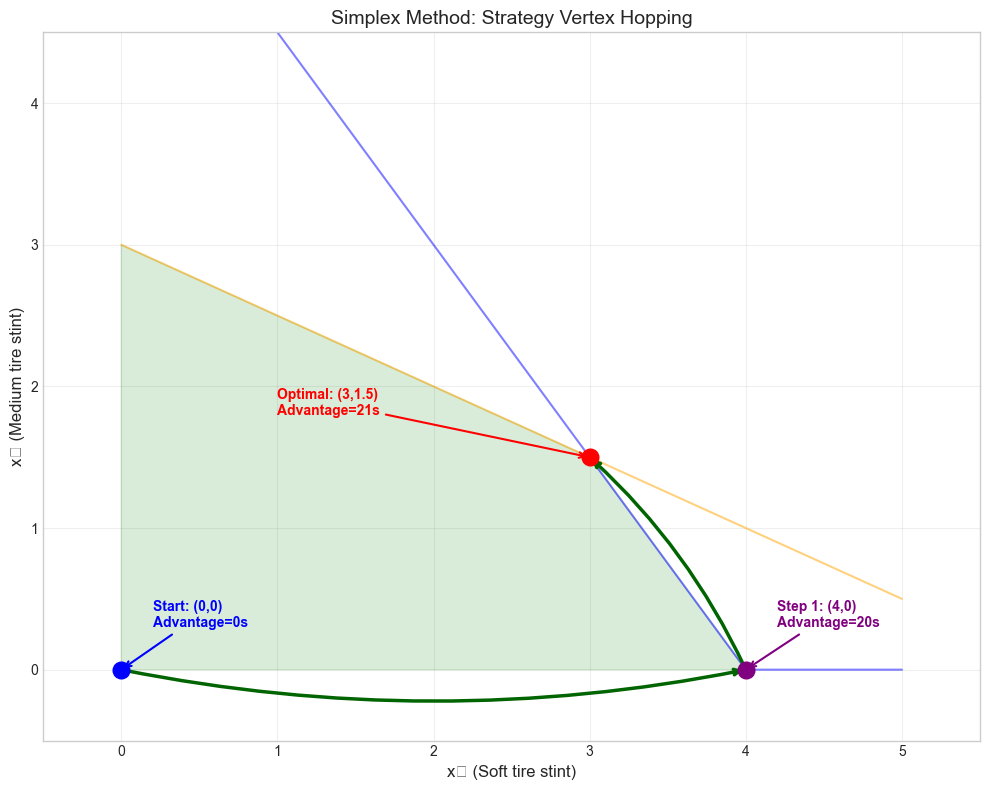

The Simplex method visits only 3 of 4 strategy vertices to find the optimum.
It never explores the interior — only vertices and edges.
Like an F1 strategist: you don't test every possible lap plan,
you iteratively tweak the best plan until no tweak helps.


In [5]:
# Visualize the Simplex method: strategy vertex hopping
# Trace the path the Simplex method takes on our race strategy LP

fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 5, 400)
y1 = (24 - 6*x) / 4
y2 = (6 - x) / 2

# Feasible region (legal strategy space)
vertices = np.array([[0, 0], [4, 0], [3, 1.5], [0, 3]])
feasible = Polygon(vertices, alpha=0.15, color='green')
ax.add_patch(feasible)
ax.plot(x, np.clip(y1, 0, 10), 'b-', linewidth=1.5, alpha=0.5)
ax.plot(x, np.clip(y2, 0, 10), color='orange', linewidth=1.5, alpha=0.5)

# Simplex path: start at "do nothing" strategy, hop along vertices
simplex_path = [
    [0, 0],     # Step 0: start at baseline (no tire advantage)
    [4, 0],     # Step 1: go all-in on softs (biggest per-lap gain)
    [3, 1.5],   # Step 2: trade some soft laps for medium laps (still improving)
]

colors_path = ['blue', 'purple', 'red']
labels = ['Start: (0,0)\nAdvantage=0s', 'Step 1: (4,0)\nAdvantage=20s', 'Optimal: (3,1.5)\nAdvantage=21s']

for i, (point, color, label) in enumerate(zip(simplex_path, colors_path, labels)):
    ax.plot(point[0], point[1], 'o', color=color, markersize=12, zorder=5)
    offset = [(0.2, 0.3), (0.2, 0.3), (-2.0, 0.3)][i]
    ax.annotate(label, xy=point, xytext=(point[0]+offset[0], point[1]+offset[1]),
                fontsize=10, fontweight='bold', color=color,
                arrowprops=dict(arrowstyle='->', color=color, lw=1.5))

# Draw path arrows
for i in range(len(simplex_path) - 1):
    start = simplex_path[i]
    end = simplex_path[i+1]
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2.5,
                                connectionstyle='arc3,rad=0.1'))

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xlabel('x₁ (Soft tire stint)', fontsize=12)
ax.set_ylabel('x₂ (Medium tire stint)', fontsize=12)
ax.set_title('Simplex Method: Strategy Vertex Hopping', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The Simplex method visits only 3 of 4 strategy vertices to find the optimum.")
print("It never explores the interior — only vertices and edges.")
print("Like an F1 strategist: you don't test every possible lap plan,")
print("you iteratively tweak the best plan until no tweak helps.")

In [6]:
def simplex_2d(c, A_ub, b_ub):
    """
    A simplified 2D Simplex implementation for educational purposes.
    Finds all vertices of the feasible polytope and evaluates the objective.
    
    This is NOT a full Simplex implementation — it is a brute-force vertex
    enumeration to illustrate the concept. Think of it as a strategist
    exhaustively checking every discrete strategy option.
    
    Args:
        c: Objective coefficients [c1, c2] (minimize c^T x)
        A_ub: Inequality constraint matrix (A_ub @ x <= b_ub)
        b_ub: Right-hand side of inequalities
    
    Returns:
        Tuple of (optimal_vertex, optimal_value, all_vertices)
    """
    from itertools import combinations
    
    c = np.array(c)
    A = np.array(A_ub)
    b = np.array(b_ub)
    
    # Add non-negativity constraints: -x1 <= 0, -x2 <= 0
    A_full = np.vstack([A, [[-1, 0], [0, -1]]])
    b_full = np.concatenate([b, [0, 0]])
    
    n_constraints = len(A_full)
    vertices = []
    
    # Find all intersections of pairs of constraint lines
    for i, j in combinations(range(n_constraints), 2):
        A_pair = A_full[[i, j]]
        b_pair = b_full[[i, j]]
        try:
            vertex = np.linalg.solve(A_pair, b_pair)
            # Check if this vertex satisfies ALL constraints (regulations)
            if np.all(A_full @ vertex <= b_full + 1e-10):
                vertices.append(vertex)
        except np.linalg.LinAlgError:
            continue  # Parallel constraints, no intersection
    
    if not vertices:
        return None, None, []
    
    vertices = np.array(vertices)
    # Remove duplicates
    unique = [vertices[0]]
    for v in vertices[1:]:
        if not any(np.allclose(v, u) for u in unique):
            unique.append(v)
    vertices = np.array(unique)
    
    # Evaluate objective at each vertex (each candidate strategy)
    obj_values = vertices @ c
    best_idx = np.argmin(obj_values)
    
    return vertices[best_idx], obj_values[best_idx], vertices


# Test on our race strategy problem (minimize -5x1 - 4x2)
opt_vertex, opt_value, all_vertices = simplex_2d(
    c=[-5, -4],
    A_ub=[[6, 4], [1, 2]],
    b_ub=[24, 6]
)

print("=== Simplified Simplex (Strategy Vertex Enumeration) ===")
print(f"\nAll legal strategy vertices:")
for v in all_vertices:
    advantage = 5*v[0] + 4*v[1]
    print(f"  Soft={v[0]:.2f}, Medium={v[1]:.2f} -> Time advantage = {advantage:.2f}s")
print(f"\nOptimal strategy: Soft={opt_vertex[0]:.2f}, Medium={opt_vertex[1]:.2f}")
print(f"Maximum time advantage: {-opt_value:.2f}s")

=== Simplified Simplex (Strategy Vertex Enumeration) ===

All legal strategy vertices:
  Soft=3.00, Medium=1.50 -> Time advantage = 21.00s
  Soft=4.00, Medium=-0.00 -> Time advantage = 20.00s
  Soft=0.00, Medium=3.00 -> Time advantage = 12.00s
  Soft=-0.00, Medium=-0.00 -> Time advantage = -0.00s

Optimal strategy: Soft=3.00, Medium=1.50
Maximum time advantage: 21.00s


### Deep Dive: Simplex vs Interior Point Methods

The Simplex method walks along edges of the polytope. An alternative family of algorithms — **interior point methods** — takes a very different approach: they walk *through the interior* of the polytope, approaching the optimal vertex from inside.

**F1 analogy:** The Simplex method is like trying different discrete strategies: "pit on lap 12, no — lap 15, no — lap 18." Interior point methods are more like continuously refining a strategy simulation, starting with a rough average plan and homing in on the optimal one.

| Property | Simplex | Interior Point |
|----------|---------|----------------|
| Path | Along edges (vertex to vertex) | Through the interior |
| Worst case | Exponential | Polynomial |
| Practical speed | Very fast for most LPs | Slightly slower on small LPs, faster on huge ones |
| Solution type | Exact vertex solution | Approaches vertex asymptotically |
| Used in `scipy` | `method='revised simplex'` | `method='highs'` (default, hybrid) |

**What this means for ML:** Most modern LP/QP solvers (like those inside SVM implementations) use interior point methods because they have reliable polynomial-time guarantees.

---

## 4. Duality Theory

### Intuitive Explanation

Every linear program (the **primal**) has a companion problem called the **dual**. If the primal asks "What is the minimum cost to meet these requirements?", the dual asks "What is the maximum value of the resources?"

### The F1 Connection

Duality shows up naturally in F1. Consider a team allocating resources between two drivers:
- **Team principal's view (primal):** "What is the minimum total budget to give both drivers competitive cars?"
- **Driver's view (dual):** "What is the maximum performance value of the budget I have been allocated?"

Both perspectives describe the same underlying resource allocation problem, just from different sides of the pit wall.

**Primal (minimize):**
$$\min_{x} \mathbf{c}^T \mathbf{x} \quad \text{s.t.} \quad A\mathbf{x} \geq \mathbf{b}, \; \mathbf{x} \geq 0$$

**Dual (maximize):**
$$\max_{y} \mathbf{b}^T \mathbf{y} \quad \text{s.t.} \quad A^T\mathbf{y} \leq \mathbf{c}, \; \mathbf{y} \geq 0$$

The dual variables $\mathbf{y}$ are sometimes called **shadow prices** — they tell you how much the optimal objective would change if you relaxed a constraint by one unit. In F1: "How much faster would we go if the fuel flow limit increased by 1 kg/hr?" That is the shadow price of the fuel flow regulation.

### Key Duality Theorems

1. **Weak Duality:** The dual objective is always a lower bound for the primal:
   $$\mathbf{b}^T \mathbf{y} \leq \mathbf{c}^T \mathbf{x} \quad \text{(for all feasible } x, y\text{)}$$

2. **Strong Duality:** At optimality, the bounds meet exactly:
   $$\mathbf{b}^T \mathbf{y}^* = \mathbf{c}^T \mathbf{x}^*$$

3. **Complementary Slackness:** At optimality, either a constraint is tight (active) or its dual variable is zero. No resource is both unused and valued. In F1: if you have leftover tire sets at the end of the race, those tire sets had zero shadow price — they were not the binding constraint.

**What this means:** Duality gives us two views of the same problem. If we can solve the dual, we automatically get the primal solution (and vice versa). In ML, the SVM dual formulation is actually easier to solve than the primal.

In [7]:
# Demonstrate duality with a concrete example
# F1 framing: minimum-cost resource allocation to meet driver performance targets
# Primal: min c^T x  s.t. Ax >= b, x >= 0
# Reformulated as: min c^T x  s.t. -Ax <= -b, x >= 0 (for linprog)

# Primal problem (team principal's view):
# min 4*aero_budget + 3*engine_budget (total spending)
# s.t.  2*aero + 1*engine >= 8  (Driver 1 performance target)
#        1*aero + 2*engine >= 6  (Driver 2 performance target)
#        aero, engine >= 0

# Primal with linprog (convert >= to <=)
c_primal = [4, 3]
A_primal = [[-2, -1], [-1, -2]]  # negated for <=
b_primal = [-8, -6]

result_primal = linprog(c_primal, A_ub=A_primal, b_ub=b_primal,
                        bounds=[(0, None), (0, None)], method='highs')

# Dual problem (driver's view — value of performance targets):
# max 8*y1 + 6*y2 -> min -8*y1 - 6*y2
# s.t.  2*y1 + y2 <= 4   (aero value can't exceed aero cost)
#        y1 + 2*y2 <= 3   (engine value can't exceed engine cost)
#        y1, y2 >= 0

c_dual = [-8, -6]  # negated for minimization
A_dual = [[2, 1], [1, 2]]
b_dual = [4, 3]

result_dual = linprog(c_dual, A_ub=A_dual, b_ub=b_dual,
                      bounds=[(0, None), (0, None)], method='highs')

print("=== Primal-Dual Comparison (Team vs Driver View) ===")
print(f"\nPrimal (team) optimal allocation: aero={result_primal.x[0]:.4f}, engine={result_primal.x[1]:.4f}")
print(f"Primal optimal cost: {result_primal.fun:.4f}")
print(f"\nDual (driver) shadow prices: y1={result_dual.x[0]:.4f}, y2={result_dual.x[1]:.4f}")
print(f"Dual optimal value: {-result_dual.fun:.4f}")  # negate back
print(f"\nStrong duality holds: {np.isclose(result_primal.fun, -result_dual.fun)}")
print(f"Duality gap: {abs(result_primal.fun - (-result_dual.fun)):.10f}")

=== Primal-Dual Comparison (Team vs Driver View) ===

Primal (team) optimal allocation: aero=3.3333, engine=1.3333
Primal optimal cost: 17.3333

Dual (driver) shadow prices: y1=1.6667, y2=0.6667
Dual optimal value: 17.3333

Strong duality holds: True
Duality gap: 0.0000000000


/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/419004724.py:59: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/419004724.py:59: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


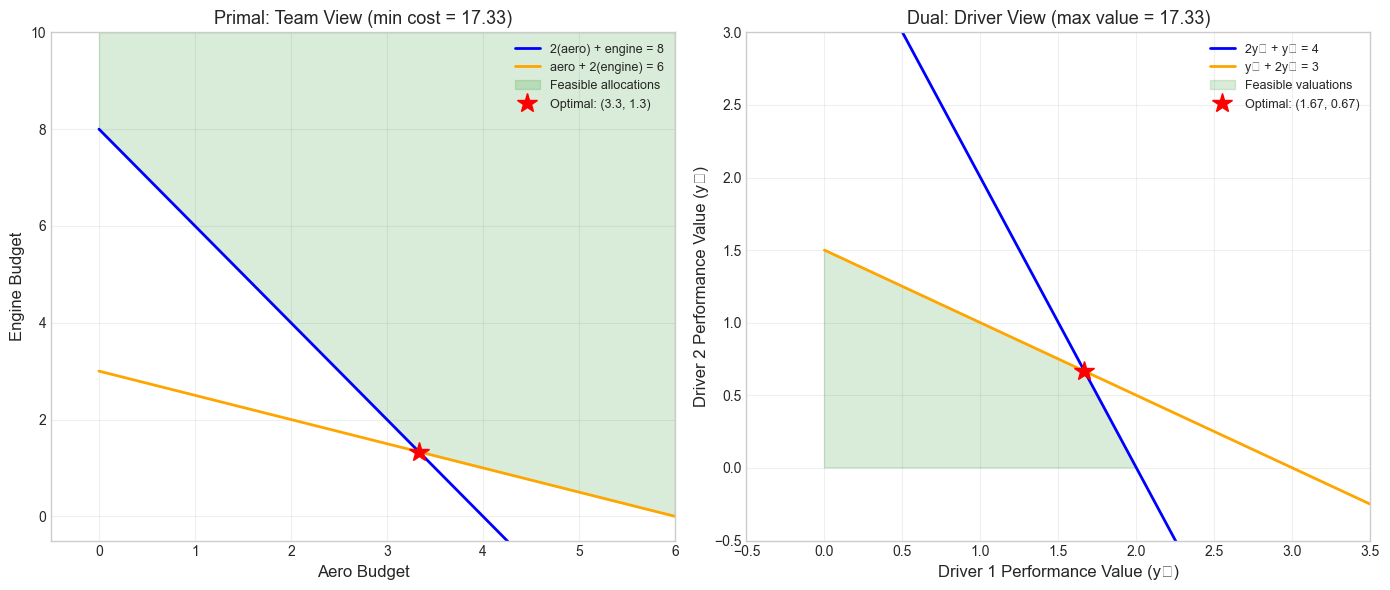

Strong duality: both problems achieve the same optimal value.
The dual variables (shadow prices) tell us: how much total cost would
decrease if we relaxed a driver's performance target by one unit.


In [8]:
# Visualize primal and dual feasible regions side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.linspace(0, 6, 400)

# --- Primal (Team Principal's View) ---
ax = axes[0]
# Constraints: 2*aero + engine >= 8, aero + 2*engine >= 6
y_c1 = 8 - 2*x       # engine >= 8 - 2*aero
y_c2 = (6 - x) / 2   # engine >= (6 - aero)/2

ax.plot(x, y_c1, 'b-', linewidth=2, label='2(aero) + engine = 8')
ax.plot(x, y_c2, color='orange', linewidth=2, label='aero + 2(engine) = 6')

# Fill feasible region (above both lines)
y_lower = np.maximum(y_c1, y_c2)
y_lower = np.maximum(y_lower, 0)
ax.fill_between(x, y_lower, 10, where=(y_lower <= 10) & (x >= 0),
                alpha=0.15, color='green', label='Feasible allocations')

# Optimal point
ax.plot(result_primal.x[0], result_primal.x[1], 'r*', markersize=15,
        label=f'Optimal: ({result_primal.x[0]:.1f}, {result_primal.x[1]:.1f})', zorder=5)

ax.set_xlim(-0.5, 6)
ax.set_ylim(-0.5, 10)
ax.set_xlabel('Aero Budget', fontsize=12)
ax.set_ylabel('Engine Budget', fontsize=12)
ax.set_title(f'Primal: Team View (min cost = {result_primal.fun:.2f})', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Dual (Driver's View) ---
ax = axes[1]
# Constraints: 2y1 + y2 <= 4, y1 + 2y2 <= 3
y_d1 = 4 - 2*x       # y2 <= 4 - 2y1
y_d2 = (3 - x) / 2   # y2 <= (3 - y1)/2

ax.plot(x, y_d1, 'b-', linewidth=2, label='2y₁ + y₂ = 4')
ax.plot(x, y_d2, color='orange', linewidth=2, label='y₁ + 2y₂ = 3')

# Feasible region vertices for dual
dual_verts = np.array([[0, 0], [2, 0], [5/3, 2/3], [0, 1.5]])
dual_poly = Polygon(dual_verts, alpha=0.15, color='green', label='Feasible valuations')
ax.add_patch(dual_poly)

# Optimal point
ax.plot(result_dual.x[0], result_dual.x[1], 'r*', markersize=15,
        label=f'Optimal: ({result_dual.x[0]:.2f}, {result_dual.x[1]:.2f})', zorder=5)

ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 3)
ax.set_xlabel('Driver 1 Performance Value (y₁)', fontsize=12)
ax.set_ylabel('Driver 2 Performance Value (y₂)', fontsize=12)
ax.set_title(f'Dual: Driver View (max value = {-result_dual.fun:.2f})', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Strong duality: both problems achieve the same optimal value.")
print("The dual variables (shadow prices) tell us: how much total cost would")
print("decrease if we relaxed a driver's performance target by one unit.")

### Deep Dive: Why Duality Matters in ML

Duality is not just a theoretical curiosity — it is the engine behind several important ML algorithms:

| ML Application | How Duality is Used | F1 Parallel |
|----------------|---------------------|-------------|
| **Support Vector Machines** | The SVM primal is hard (minimize over $w, b$). The dual is easier and reveals the kernel trick. | Team vs driver view of the same budget allocation |
| **Regularization** | Adding an $\ell_2$ penalty is equivalent to constraining the norm (Lagrangian duality). | Budget cap = penalty on spending; weight limit = constraint on car mass |
| **Maximum Entropy Models** | The dual of the constrained entropy problem yields logistic regression. | Maximizing unpredictability within known track constraints |
| **Variational Inference** | ELBO (Evidence Lower BOund) is a dual bound on the marginal likelihood. | Lower bound on expected race pace given incomplete data |

#### Key Insight

The dual often reveals hidden structure. For SVMs, the dual formulation depends only on dot products of data points $\langle x_i, x_j \rangle$, which lets us use the **kernel trick** to work in infinite-dimensional feature spaces. Similarly, in F1, looking at the same problem from the regulation side (dual) versus the strategy side (primal) often reveals which constraints actually matter.

---

## 5. Convex Optimization

### Intuitive Explanation

A set is **convex** if the line segment between any two points in the set lies entirely within the set. Think of a filled circle (convex) versus a crescent moon (not convex).

A function is **convex** if it curves upward — like a bowl. Formally, $f$ is convex if:

$$f(\lambda x + (1-\lambda)y) \leq \lambda f(x) + (1-\lambda)f(y) \quad \forall \lambda \in [0,1]$$

**What this means:** Draw a line between any two points on the function's graph. If the function always lies below (or on) the line, it is convex. A bowl has this property; a roller coaster does not.

### The F1 Connection

Think of **car setup optimization** as a landscape. For many setup parameters (like spring stiffness or anti-roll bar setting), the lap time response is approximately convex — a smooth bowl where the optimal setting sits at the bottom. This is the "sweet spot" engineers talk about. You can find it by gradient descent (adjusting setup incrementally), and you will not get stuck in a false minimum.

But **full car design** — combining aero, engine, suspension, and electronics — is highly non-convex. There are multiple local minima (design philosophies that each work but are very different), and getting stuck in one requires a radical concept change to escape. Red Bull's 2022 car and Mercedes' "zero-pod" concept were two very different local minima.

### Why Convexity Matters

**The fundamental theorem of convex optimization:** For a convex function over a convex set, every local minimum is a global minimum.

This means:
- No getting stuck in local minima
- Gradient descent is guaranteed to find the global optimum
- The solution is unique (for strictly convex functions)

This is why much of ML theory revolves around convex loss functions (squared error, cross-entropy, hinge loss) and convex regularizers ($\ell_1$, $\ell_2$).

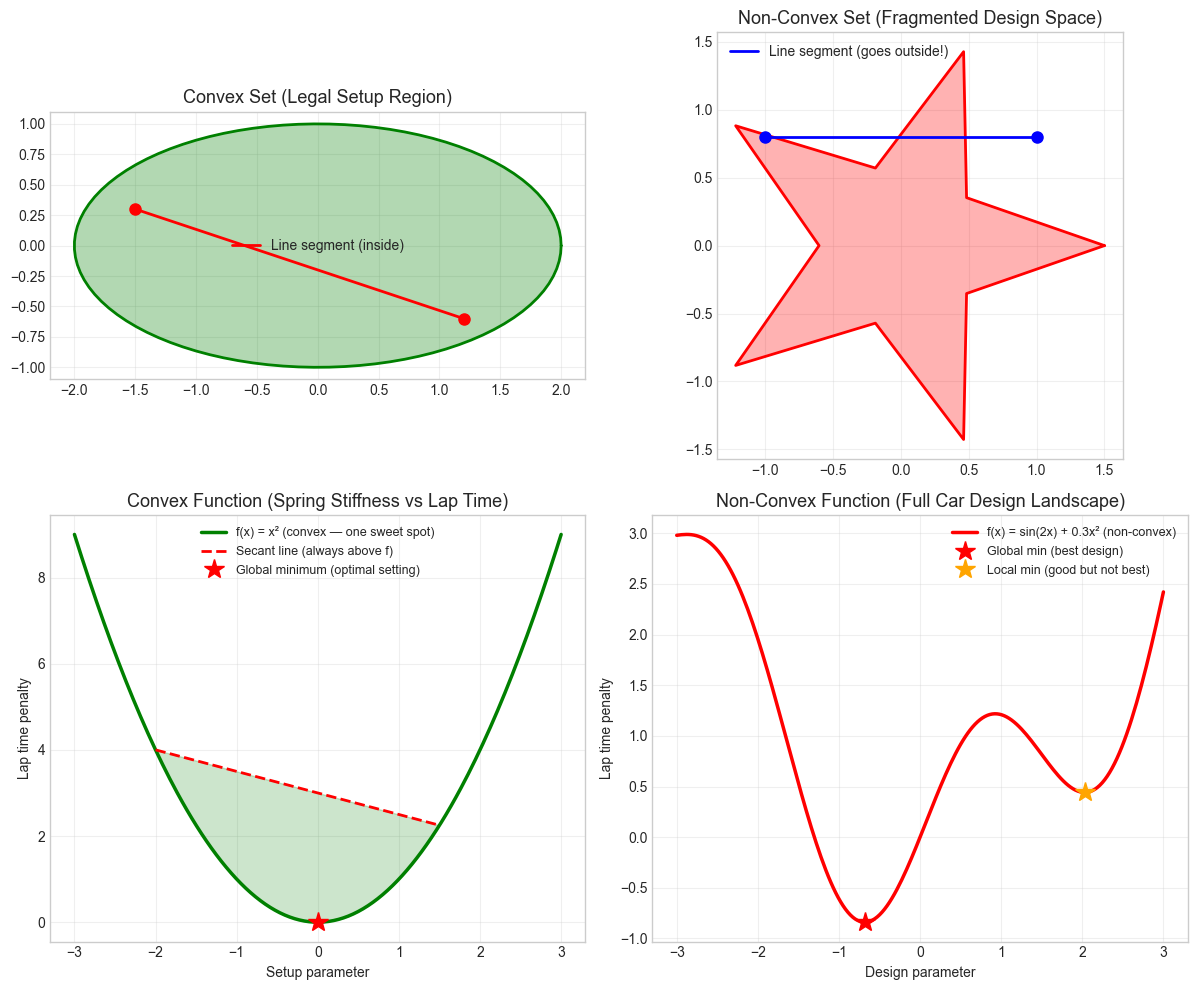

Top row: Convex sets pass the line-segment test; non-convex sets fail it.
Bottom row: Convex functions have one minimum; non-convex functions may have many.

F1 insight: a spring stiffness setting has a smooth optimal (convex).
Full car design is non-convex — different philosophies can each be local optima.


In [9]:
# Visualize convex vs non-convex sets and functions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Top Left: Convex set (smooth oval — like a valid setup parameter region) ---
ax = axes[0, 0]
theta = np.linspace(0, 2*np.pi, 100)
# Ellipse (convex)
cx, cy = 2*np.cos(theta), np.sin(theta)
ax.fill(cx, cy, alpha=0.3, color='green')
ax.plot(cx, cy, 'g-', linewidth=2)
# Show line segment test
p1, p2 = np.array([-1.5, 0.3]), np.array([1.2, -0.6])
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=2, label='Line segment (inside)')
ax.plot(*p1, 'ro', markersize=8)
ax.plot(*p2, 'ro', markersize=8)
ax.set_title('Convex Set (Legal Setup Region)', fontsize=13)
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Top Right: Non-convex set (star shape — like a fragmented regulation space) ---
ax = axes[0, 1]
# Star shape (non-convex)
angles = np.linspace(0, 2*np.pi, 11)
radii = [1.5 if i % 2 == 0 else 0.6 for i in range(11)]
sx = [r*np.cos(a) for r, a in zip(radii, angles)]
sy = [r*np.sin(a) for r, a in zip(radii, angles)]
ax.fill(sx, sy, alpha=0.3, color='red')
ax.plot(sx, sy, 'r-', linewidth=2)
# Show line segment test failing
p1, p2 = np.array([-1.0, 0.8]), np.array([1.0, 0.8])
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', linewidth=2, label='Line segment (goes outside!)')
ax.plot(*p1, 'bo', markersize=8)
ax.plot(*p2, 'bo', markersize=8)
ax.set_title('Non-Convex Set (Fragmented Design Space)', fontsize=13)
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Bottom Left: Convex function (single-parameter setup: one sweet spot) ---
ax = axes[1, 0]
x = np.linspace(-3, 3, 200)
y_convex = x**2
ax.plot(x, y_convex, 'g-', linewidth=2.5, label='f(x) = x² (convex — one sweet spot)')
# Secant line
xa, xb = -2, 1.5
ya, yb = xa**2, xb**2
ax.plot([xa, xb], [ya, yb], 'r--', linewidth=2, label='Secant line (always above f)')
ax.fill_between(x[(x >= xa) & (x <= xb)],
                x[(x >= xa) & (x <= xb)]**2,
                np.interp(x[(x >= xa) & (x <= xb)], [xa, xb], [ya, yb]),
                alpha=0.2, color='green')
ax.plot(0, 0, 'r*', markersize=15, label='Global minimum (optimal setting)', zorder=5)
ax.set_title('Convex Function (Spring Stiffness vs Lap Time)', fontsize=13)
ax.set_xlabel('Setup parameter')
ax.set_ylabel('Lap time penalty')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Bottom Right: Non-convex function (multi-parameter: multiple local minima) ---
ax = axes[1, 1]
y_nonconvex = np.sin(2*x) + 0.3*x**2
ax.plot(x, y_nonconvex, 'r-', linewidth=2.5, label='f(x) = sin(2x) + 0.3x² (non-convex)')
# Mark local minima
from scipy.signal import argrelmin
local_mins = argrelmin(y_nonconvex, order=20)[0]
for lm in local_mins:
    color = 'red' if y_nonconvex[lm] == min(y_nonconvex[local_mins]) else 'orange'
    label = 'Global min (best design)' if color == 'red' else 'Local min (good but not best)'
    ax.plot(x[lm], y_nonconvex[lm], '*', color=color, markersize=15, zorder=5, label=label)
ax.set_title('Non-Convex Function (Full Car Design Landscape)', fontsize=13)
ax.set_xlabel('Design parameter')
ax.set_ylabel('Lap time penalty')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Top row: Convex sets pass the line-segment test; non-convex sets fail it.")
print("Bottom row: Convex functions have one minimum; non-convex functions may have many.")
print("\nF1 insight: a spring stiffness setting has a smooth optimal (convex).")
print("Full car design is non-convex — different philosophies can each be local optima.")

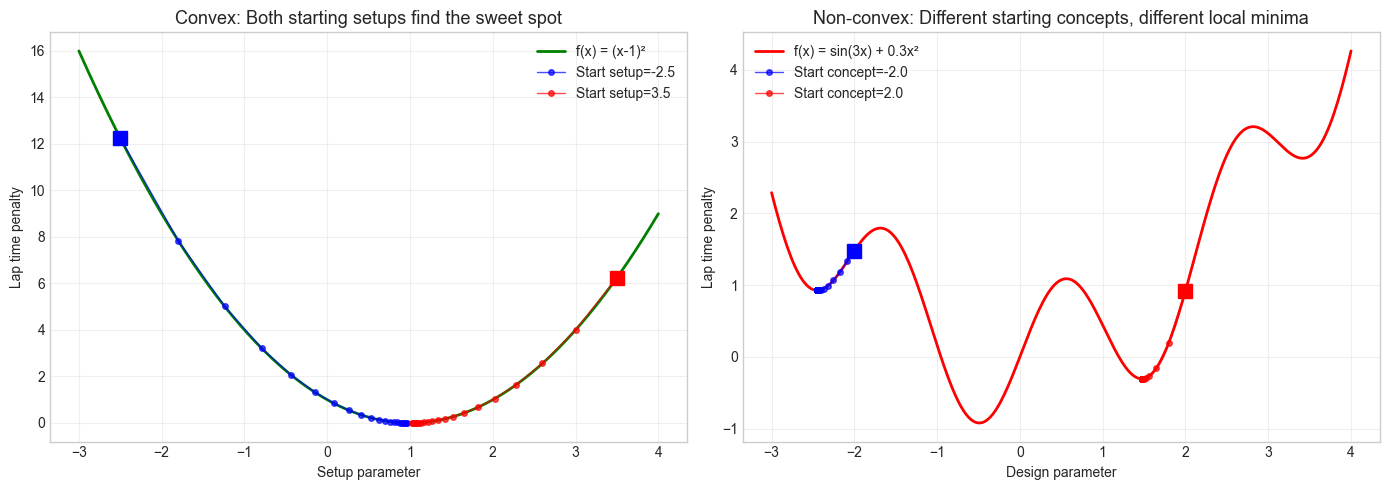

Convex (spring stiffness): Every starting point leads to the same optimal setup.
Non-convex (car design): Different starting concepts can converge to different designs.

This is why neural network training (non-convex) depends on initialization,
while logistic regression (convex) converges to the same solution regardless.
And why F1 teams sometimes need a bold concept reset to escape a local minimum.


In [10]:
# Demonstrate: gradient descent finds the global optimum on convex functions
# but can get stuck on non-convex functions
# F1 analogy: setup tuning (convex) vs full car design (non-convex)

def gradient_descent_1d(f, df, x0, lr=0.1, n_steps=30):
    """
    Simple 1D gradient descent — like an engineer incrementally tweaking a setup parameter.
    
    Args:
        f: Objective function (lap time penalty)
        df: Gradient of objective (sensitivity to parameter change)
        x0: Starting point (initial setup)
        lr: Learning rate (how big each setup change is)
        n_steps: Number of iterations
    
    Returns:
        List of (x, f(x)) at each step
    """
    path = [(x0, f(x0))]
    x = x0
    for _ in range(n_steps):
        x = x - lr * df(x)
        path.append((x, f(x)))
    return path


# Convex: f(x) = (x-1)^2 — like spring stiffness optimization
f_convex = lambda x: (x - 1)**2
df_convex = lambda x: 2*(x - 1)

# Non-convex: f(x) = sin(3x) + 0.3*x^2 — like full car design
f_nonconvex = lambda x: np.sin(3*x) + 0.3*x**2
df_nonconvex = lambda x: 3*np.cos(3*x) + 0.6*x

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_range = np.linspace(-3, 4, 300)

# Convex case (spring stiffness — any starting point finds the sweet spot)
ax = axes[0]
ax.plot(x_range, f_convex(x_range), 'g-', linewidth=2, label='f(x) = (x-1)²')
for x0, color, ls in [(-2.5, 'blue', '-'), (3.5, 'red', '--')]:
    path = gradient_descent_1d(f_convex, df_convex, x0, lr=0.1, n_steps=20)
    xs, ys = zip(*path)
    ax.plot(xs, ys, 'o-', color=color, markersize=4, linewidth=1, alpha=0.7,
            label=f'Start setup={x0}')
    ax.plot(xs[0], ys[0], 's', color=color, markersize=10)
ax.set_title('Convex: Both starting setups find the sweet spot', fontsize=13)
ax.set_xlabel('Setup parameter')
ax.set_ylabel('Lap time penalty')
ax.legend()
ax.grid(True, alpha=0.3)

# Non-convex case (full car design — starting concept matters)
ax = axes[1]
ax.plot(x_range, f_nonconvex(x_range), 'r-', linewidth=2, label='f(x) = sin(3x) + 0.3x²')
for x0, color, ls in [(-2.0, 'blue', '-'), (2.0, 'red', '--')]:
    path = gradient_descent_1d(f_nonconvex, df_nonconvex, x0, lr=0.05, n_steps=40)
    xs, ys = zip(*path)
    ax.plot(xs, ys, 'o-', color=color, markersize=4, linewidth=1, alpha=0.7,
            label=f'Start concept={x0}')
    ax.plot(xs[0], ys[0], 's', color=color, markersize=10)
ax.set_title('Non-convex: Different starting concepts, different local minima', fontsize=13)
ax.set_xlabel('Design parameter')
ax.set_ylabel('Lap time penalty')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Convex (spring stiffness): Every starting point leads to the same optimal setup.")
print("Non-convex (car design): Different starting concepts can converge to different designs.")
print("\nThis is why neural network training (non-convex) depends on initialization,")
print("while logistic regression (convex) converges to the same solution regardless.")
print("And why F1 teams sometimes need a bold concept reset to escape a local minimum.")

### Deep Dive: Common Convex Functions in ML

Many loss functions used in ML are convex by design:

| Function | Formula | Convex? | Used in | F1 Parallel |
|----------|---------|---------|----------|-------------|
| **Squared error** | $(y - \hat{y})^2$ | Yes (strictly) | Linear regression | Lap time vs predicted lap time (squared gap) |
| **Cross-entropy** | $-y \log \hat{y} - (1-y)\log(1-\hat{y})$ | Yes (strictly) | Logistic regression | Rain probability calibration |
| **Hinge loss** | $\max(0, 1 - y \hat{y})$ | Yes (not strictly) | SVM | Penalty for being on the wrong side of the strategy cutoff |
| **$\ell_2$ penalty** | $\|\mathbf{w}\|_2^2$ | Yes (strictly) | Ridge regression | Budget cap penalty (quadratic cost of overspending) |
| **$\ell_1$ penalty** | $\|\mathbf{w}\|_1$ | Yes (not strictly) | LASSO | Weight ballast allocation (each kg costs the same) |
| **Neural network loss** | Complex composition | No (generally) | Deep learning | Full car performance sim (highly non-convex) |

#### Key Insight

A sum of convex functions is convex. This is why "loss + regularization" stays convex when both components are convex: the composite objective inherits the nice optimization properties of its parts. In F1 terms, if each sub-system (aero, engine, suspension) has a convex performance curve, and the total lap time is a weighted sum of these, the total is also convex — making optimization tractable.

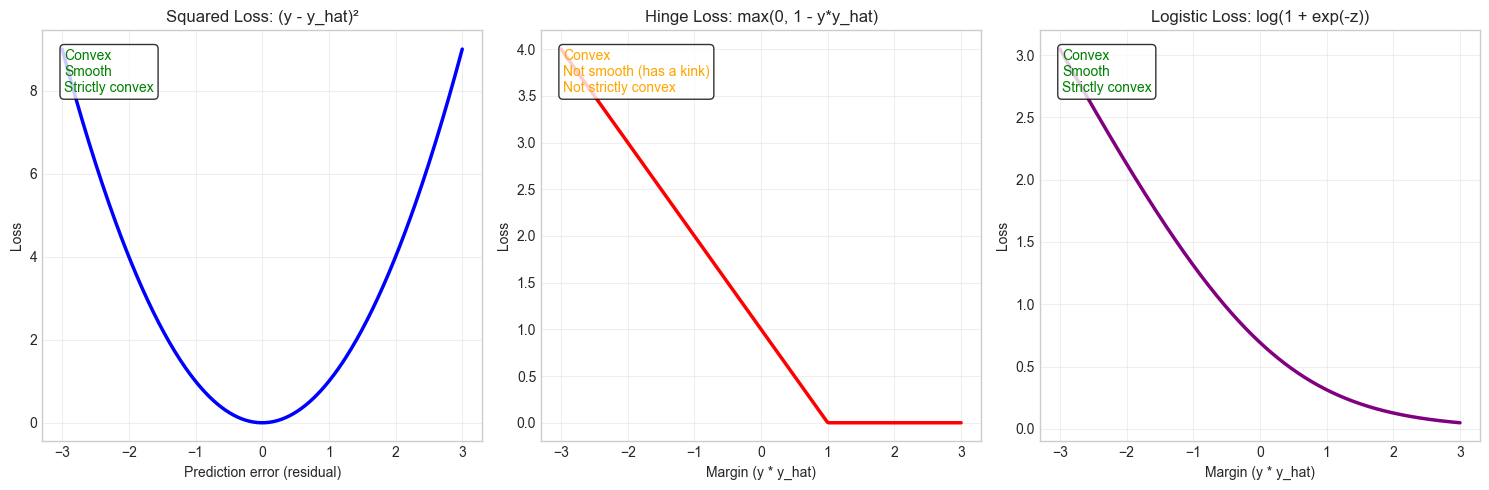

All three are convex — gradient descent will find the global minimum.
Squared loss is smooth and easy to optimize.
Hinge loss has a 'kink' at 1, requiring subgradient methods.
Logistic loss is a smooth approximation of hinge loss.

F1 parallel: all three are like single-parameter setup curves — one clear optimum.


In [11]:
# Visualize common ML loss functions and their convexity
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

z = np.linspace(-3, 3, 300)

# Squared loss
ax = axes[0]
ax.plot(z, z**2, 'b-', linewidth=2.5)
ax.set_title('Squared Loss: (y - y_hat)²', fontsize=12)
ax.set_xlabel('Prediction error (residual)')
ax.set_ylabel('Loss')
ax.text(0.05, 0.85, 'Convex\nSmooth\nStrictly convex',
        transform=ax.transAxes, fontsize=10, color='green',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.grid(True, alpha=0.3)

# Hinge loss
ax = axes[1]
hinge = np.maximum(0, 1 - z)
ax.plot(z, hinge, 'r-', linewidth=2.5)
ax.set_title('Hinge Loss: max(0, 1 - y*y_hat)', fontsize=12)
ax.set_xlabel('Margin (y * y_hat)')
ax.set_ylabel('Loss')
ax.text(0.05, 0.85, 'Convex\nNot smooth (has a kink)\nNot strictly convex',
        transform=ax.transAxes, fontsize=10, color='orange',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.grid(True, alpha=0.3)

# Cross-entropy / logistic loss
ax = axes[2]
logistic_loss = np.log(1 + np.exp(-z))
ax.plot(z, logistic_loss, 'purple', linewidth=2.5)
ax.set_title('Logistic Loss: log(1 + exp(-z))', fontsize=12)
ax.set_xlabel('Margin (y * y_hat)')
ax.set_ylabel('Loss')
ax.text(0.05, 0.85, 'Convex\nSmooth\nStrictly convex',
        transform=ax.transAxes, fontsize=10, color='green',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("All three are convex — gradient descent will find the global minimum.")
print("Squared loss is smooth and easy to optimize.")
print("Hinge loss has a 'kink' at 1, requiring subgradient methods.")
print("Logistic loss is a smooth approximation of hinge loss.")
print("\nF1 parallel: all three are like single-parameter setup curves — one clear optimum.")

---

## 6. Constrained Optimization & Lagrange Multipliers

### Intuitive Explanation

How do you minimize a function when you must stay on a specific curve or surface? This is the **constrained optimization** problem.

**The setup:**
$$\min_{x} f(x) \quad \text{subject to} \quad g(x) = 0$$

**Lagrange's insight (1788):** At the constrained optimum, the gradient of the objective $\nabla f$ must be parallel to the gradient of the constraint $\nabla g$. If they were not parallel, you could slide along the constraint and still improve the objective.

This gives us the **Lagrangian**:
$$\mathcal{L}(x, \lambda) = f(x) + \lambda \, g(x)$$

The optimal point satisfies:
$$\nabla_x \mathcal{L} = 0 \quad \text{and} \quad \nabla_\lambda \mathcal{L} = 0$$

The variable $\lambda$ is called the **Lagrange multiplier**. It tells you the rate at which the optimal objective value changes as you relax the constraint.

### The F1 Connection

Imagine you want to **minimize lap time** (the objective) but the FIA requires a **minimum car weight** of 798 kg (the constraint). You cannot just build the lightest car possible — you must hit exactly 798 kg.

The Lagrange multiplier $\lambda$ answers the question every team asks: "If the FIA dropped the minimum weight by 1 kg, how much faster would our lap time be?" That sensitivity — seconds per kilogram — is the shadow price of the weight regulation.

**Hiking analogy:** Imagine hiking downhill but you must stay on a trail (the constraint). You stop when the steepest downhill direction is perpendicular to the trail — because moving along the trail no longer takes you downhill.

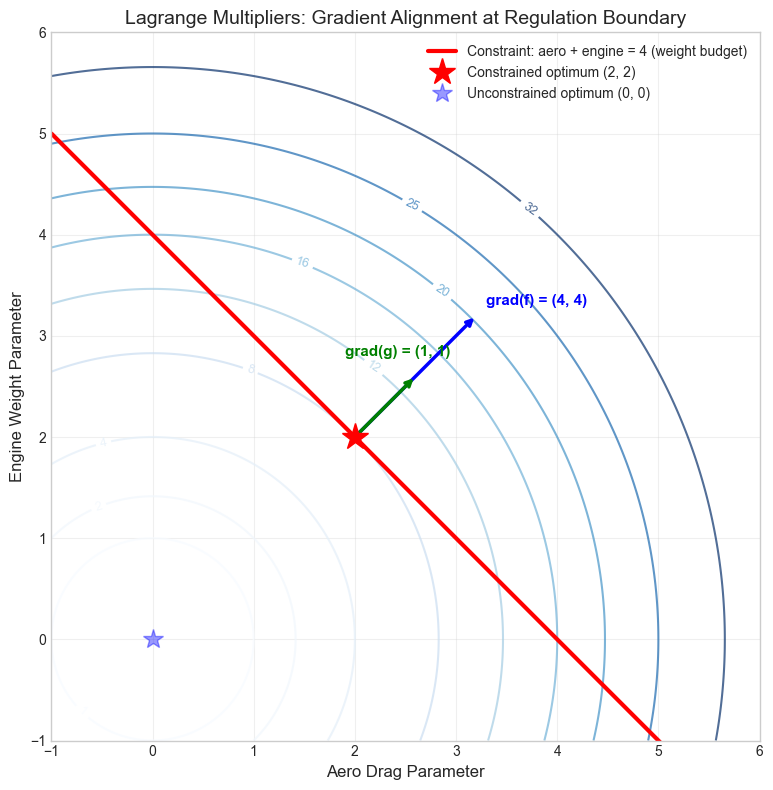

At the constrained optimum (2, 2):
  grad(f) = (4, 4) is parallel to grad(g) = (1, 1)
  lambda = 4 (the Lagrange multiplier: grad(f) = lambda * grad(g))
  The multiplier lambda = 4 means: relaxing the weight budget by 1 unit
  would improve the combined penalty by approximately 4 units.
  In F1 terms: each kg of weight relief is worth 4 units of performance.


In [12]:
# Geometric visualization of Lagrange multipliers
# F1: Minimize aero_drag² + engine_weight² subject to aero_drag + engine_weight = 4
# (Balance between aero efficiency and engine mass under a total weight constraint)

fig, ax = plt.subplots(figsize=(10, 8))

x_range = np.linspace(-1, 6, 300)
y_range = np.linspace(-1, 6, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + Y**2  # objective: minimize combined penalty

# Contours of the objective
levels = [1, 2, 4, 8, 12, 16, 20, 25, 32]
contour = ax.contour(X, Y, Z, levels=levels, cmap='Blues', alpha=0.7)
ax.clabel(contour, fmt='%.0f', fontsize=9)

# Constraint: aero_drag + engine_weight = 4 (total weight budget)
ax.plot(x_range, 4 - x_range, 'r-', linewidth=3, label='Constraint: aero + engine = 4 (weight budget)')

# Optimal point: x = y = 2 (by symmetry, or solve the system)
opt_x, opt_y = 2, 2
ax.plot(opt_x, opt_y, 'r*', markersize=20, zorder=5, label='Constrained optimum (2, 2)')

# Draw gradients at the optimal point
# grad f = (2x, 2y) = (4, 4)
# grad g = (1, 1)  where g(x,y) = x + y - 4
scale = 0.3
ax.annotate('', xy=(opt_x + 4*scale, opt_y + 4*scale), xytext=(opt_x, opt_y),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2.5))
ax.text(opt_x + 4*scale + 0.1, opt_y + 4*scale + 0.1, 'grad(f) = (4, 4)',
        fontsize=11, color='blue', fontweight='bold')

ax.annotate('', xy=(opt_x + 1*scale*2, opt_y + 1*scale*2), xytext=(opt_x, opt_y),
            arrowprops=dict(arrowstyle='->', color='green', lw=2.5))
ax.text(opt_x + 1*scale*2 - 0.7, opt_y + 1*scale*2 + 0.2, 'grad(g) = (1, 1)',
        fontsize=11, color='green', fontweight='bold')

# Unconstrained optimum
ax.plot(0, 0, 'b*', markersize=15, alpha=0.4, label='Unconstrained optimum (0, 0)')

ax.set_xlabel('Aero Drag Parameter', fontsize=12)
ax.set_ylabel('Engine Weight Parameter', fontsize=12)
ax.set_title('Lagrange Multipliers: Gradient Alignment at Regulation Boundary', fontsize=14)
ax.legend(fontsize=10, loc='upper right')
ax.set_aspect('equal')
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("At the constrained optimum (2, 2):")
print("  grad(f) = (4, 4) is parallel to grad(g) = (1, 1)")
print("  lambda = 4 (the Lagrange multiplier: grad(f) = lambda * grad(g))")
print("  The multiplier lambda = 4 means: relaxing the weight budget by 1 unit")
print("  would improve the combined penalty by approximately 4 units.")
print("  In F1 terms: each kg of weight relief is worth 4 units of performance.")

In [13]:
# Solving constrained optimization with scipy.optimize.minimize
# F1 problem: minimize aero_drag² + engine_weight² subject to aero + engine = 4

def lap_time_penalty(params):
    """Combined penalty: aero_drag² + engine_weight²."""
    return params[0]**2 + params[1]**2

def weight_budget_constraint(params):
    """Weight budget: aero_drag + engine_weight = 4."""
    return params[0] + params[1] - 4  # equals zero at feasibility

# Using SLSQP (Sequential Least Squares Quadratic Programming)
result = minimize(
    lap_time_penalty,
    x0=[0, 0],  # starting guess
    method='SLSQP',
    constraints={'type': 'eq', 'fun': weight_budget_constraint}
)

print("=== Constrained Optimization with scipy ===")
print(f"Optimal aero parameter:   {result.x[0]:.4f}")
print(f"Optimal engine parameter: {result.x[1]:.4f}")
print(f"Minimum penalty: {result.fun:.4f}")
print(f"Constraint satisfied: {np.isclose(weight_budget_constraint(result.x), 0)}")
print(f"Solver converged: {result.success}")

# Verify: analytical solution is (2, 2) with f = 8
print(f"\nAnalytical solution: (2, 2), f = 8")
print(f"Match: {np.allclose(result.x, [2, 2]) and np.isclose(result.fun, 8)}")

=== Constrained Optimization with scipy ===
Optimal aero parameter:   2.0000
Optimal engine parameter: 2.0000
Minimum penalty: 8.0000
Constraint satisfied: True
Solver converged: True

Analytical solution: (2, 2), f = 8
Match: True


### KKT Conditions: The Full Picture

Lagrange multipliers handle **equality** constraints. For **inequality** constraints ($g_i(x) \leq 0$), we need the **Karush-Kuhn-Tucker (KKT) conditions**, which generalize Lagrange multipliers.

For the problem:
$$\min_x f(x) \quad \text{s.t.} \quad g_i(x) \leq 0, \quad h_j(x) = 0$$

The KKT conditions are:

| Condition | Statement | Intuition | F1 Parallel |
|-----------|-----------|----------|-------------|
| **Stationarity** | $\nabla f + \sum \mu_i \nabla g_i + \sum \lambda_j \nabla h_j = 0$ | Gradient balance at optimum | All design forces in equilibrium |
| **Primal feasibility** | $g_i(x) \leq 0, \; h_j(x) = 0$ | Solution must be feasible | Car passes scrutineering |
| **Dual feasibility** | $\mu_i \geq 0$ | Inequality multipliers are non-negative | Regulations can only restrict, never help |
| **Complementary slackness** | $\mu_i \, g_i(x) = 0$ | Either constraint is active or multiplier is zero | If you are not at the weight limit, the weight rule does not affect you |

**What this means:** 
- If a constraint is **not active** ($g_i(x) < 0$, you are strictly inside the boundary), then $\mu_i = 0$ — the constraint does not affect the solution. (If your car is already heavier than the minimum weight, the weight rule is irrelevant.)
- If a constraint **is active** ($g_i(x) = 0$, you are on the boundary), then $\mu_i > 0$ — the constraint is "pushing back" and preventing you from going further. (If you are right at minimum weight, the regulation is actively constraining your design.)

For **convex** problems, the KKT conditions are both necessary and sufficient for optimality.

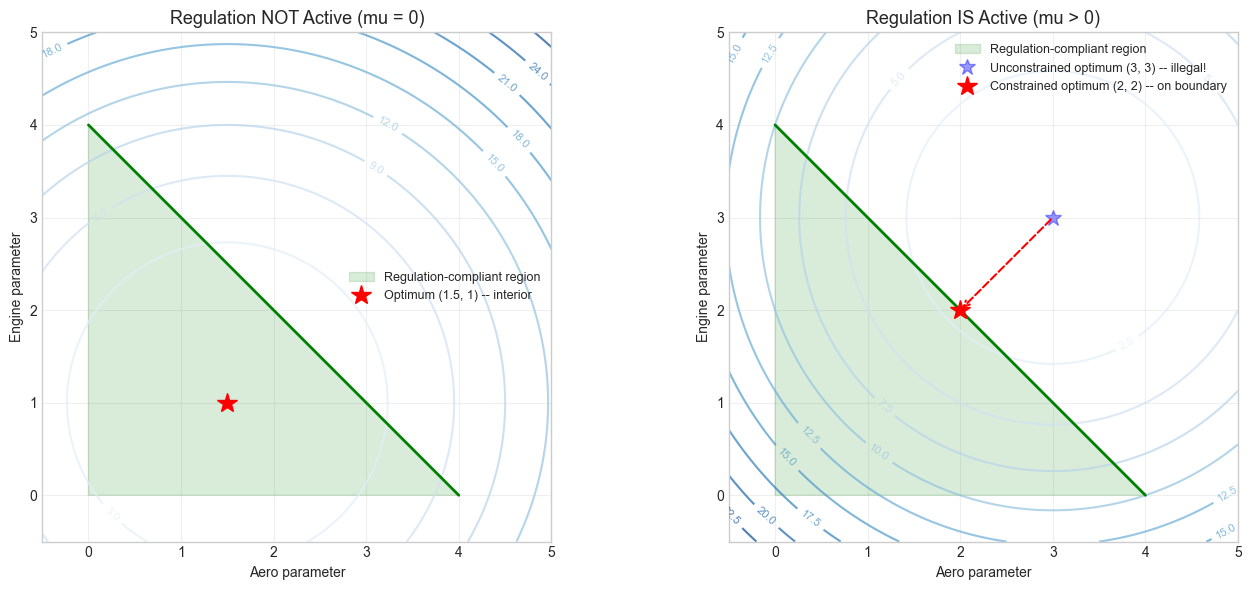

Left: The ideal design (1.5, 1) is already within regulations.
  -> The regulation is NOT active, and the multiplier mu = 0.
  -> The regulation doesn't affect the design at all (like a weight rule
     that's irrelevant because the car is already heavy enough).

Right: The ideal design (3, 3) VIOLATES regulations.
  -> The regulation IS active, forcing the design to (2, 2) on the boundary.
  -> The multiplier mu > 0, representing the performance cost of the regulation.
  -> This is exactly what happens when floor rules constrain aero development.


In [14]:
# Visualize KKT conditions: inequality constraints
# F1 scenario: minimize lap time penalty subject to weight regulations

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x_range = np.linspace(-0.5, 5, 300)
y_range = np.linspace(-0.5, 5, 300)
X, Y = np.meshgrid(x_range, y_range)

# Case 1: Optimal design is already within regulations (constraint not active)
ax = axes[0]
Z = (X - 1.5)**2 + (Y - 1)**2  # penalty landscape: optimum at (1.5, 1)
contour = ax.contour(X, Y, Z, levels=10, cmap='Blues', alpha=0.7)
ax.clabel(contour, fmt='%.1f', fontsize=8)

# Regulation region: aero + engine <= 4, both >= 0
feas_verts = np.array([[0, 0], [4, 0], [0, 4]])
feas_poly = Polygon(feas_verts, alpha=0.15, color='green', label='Regulation-compliant region')
ax.add_patch(feas_poly)
ax.plot([0, 4], [4, 0], 'g-', linewidth=2)

ax.plot(1.5, 1, 'r*', markersize=15, zorder=5, label='Optimum (1.5, 1) -- interior')
ax.set_title('Regulation NOT Active (mu = 0)', fontsize=13)
ax.set_xlabel('Aero parameter')
ax.set_ylabel('Engine parameter')
ax.legend(fontsize=9)
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5)
ax.set_ylim(-0.5, 5)
ax.grid(True, alpha=0.3)

# Case 2: Ideal design violates regulations -> constraint active
ax = axes[1]
Z2 = (X - 3)**2 + (Y - 3)**2  # penalty landscape: optimum at (3, 3) — outside regs
contour = ax.contour(X, Y, Z2, levels=10, cmap='Blues', alpha=0.7)
ax.clabel(contour, fmt='%.1f', fontsize=8)

feas_poly2 = Polygon(feas_verts, alpha=0.15, color='green', label='Regulation-compliant region')
ax.add_patch(feas_poly2)
ax.plot([0, 4], [4, 0], 'g-', linewidth=2)

# Constrained optimum: closest point on aero+engine=4 to (3,3) is (2,2)
ax.plot(3, 3, 'b*', markersize=12, alpha=0.4, label='Unconstrained optimum (3, 3) -- illegal!')
ax.plot(2, 2, 'r*', markersize=15, zorder=5, label='Constrained optimum (2, 2) -- on boundary')
ax.annotate('', xy=(2, 2), xytext=(3, 3),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5, ls='--'))

ax.set_title('Regulation IS Active (mu > 0)', fontsize=13)
ax.set_xlabel('Aero parameter')
ax.set_ylabel('Engine parameter')
ax.legend(fontsize=9)
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5)
ax.set_ylim(-0.5, 5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Left: The ideal design (1.5, 1) is already within regulations.")
print("  -> The regulation is NOT active, and the multiplier mu = 0.")
print("  -> The regulation doesn't affect the design at all (like a weight rule")
print("     that's irrelevant because the car is already heavy enough).")
print("\nRight: The ideal design (3, 3) VIOLATES regulations.")
print("  -> The regulation IS active, forcing the design to (2, 2) on the boundary.")
print("  -> The multiplier mu > 0, representing the performance cost of the regulation.")
print("  -> This is exactly what happens when floor rules constrain aero development.")

### Deep Dive: Complementary Slackness — The Either/Or Rule

Complementary slackness ($\mu_i \cdot g_i(x) = 0$) is perhaps the most elegant condition. It says:

For each inequality constraint, exactly one of two things is true:
1. The constraint is **slack** ($g_i(x) < 0$): the boundary is not reached, so the multiplier is zero ($\mu_i = 0$). In F1: the car is under the budget cap, so the cap does not affect strategy.
2. The constraint is **tight** ($g_i(x) = 0$): the boundary is hit, and the multiplier is positive ($\mu_i > 0$). In F1: the team is right at the budget cap, and every dollar matters.

In ML terms:
- In an SVM, most data points have $\mu_i = 0$ — they do not affect the decision boundary.
- Only the **support vectors** (points on the margin boundary) have $\mu_i > 0$.
- This is why SVMs are sparse: the solution depends only on a few critical data points.

**F1 parallel:** Think of regulations as constraints on car design. Most regulations are "slack" — the team is well within the limit and does not even think about them. But a few regulations are "tight" — the team is right at the boundary, and those are the ones that actually shape the car. Just like support vectors shape the SVM decision boundary.

---

## 7. Connection to Machine Learning

### ML as Optimization

Nearly every ML algorithm can be framed as an optimization problem. And every one of these has a natural F1 parallel — because F1 engineering is also, fundamentally, constrained optimization.

| Algorithm | Objective | Constraints | Type | F1 Parallel |
|-----------|-----------|-------------|------|-------------|
| **Linear regression** | $\min_w \|Xw - y\|^2$ | None | Unconstrained convex | Best-fit telemetry model |
| **Ridge regression** | $\min_w \|Xw - y\|^2 + \alpha\|w\|^2$ | None (equivalent to constrained) | Unconstrained convex | Lap time model with complexity penalty |
| **LASSO** | $\min_w \|Xw - y\|^2 + \alpha\|w\|_1$ | None (equivalent to constrained) | Unconstrained convex | Feature-sparse telemetry model |
| **Logistic regression** | $\min_w \sum \log(1 + e^{-y_i w^T x_i})$ | None | Unconstrained convex | Rain/dry race outcome prediction |
| **SVM (primal)** | $\min_{w,b} \frac{1}{2}\|w\|^2$ | $y_i(w^T x_i + b) \geq 1$ | Constrained convex (QP) | Maximum-margin tire strategy classifier |
| **SVM (dual)** | $\max_\alpha \sum \alpha_i - \frac{1}{2}\sum \alpha_i \alpha_j y_i y_j x_i^T x_j$ | $0 \leq \alpha_i \leq C$ | Constrained convex (QP) | Driver-view of the same classifier |
| **Neural networks** | $\min_\theta \mathcal{L}(f_\theta(X), y)$ | None | Unconstrained **non-convex** | Full race strategy simulator |

Notice: everything except neural networks is convex. This is why classical ML has nice convergence guarantees, while deep learning requires more art (learning rate schedules, initialization strategies, etc.) — just like how tuning a single spring is straightforward, but designing an entire F1 car from scratch is a deeply non-convex challenge.

In [15]:
# Demonstrate: SVM as a constrained optimization problem
# F1 framing: classifying race strategies as "aggressive" vs "conservative"
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

# Generate data: two clusters representing aggressive vs conservative strategies
np.random.seed(42)
X_train, y_train = make_blobs(n_samples=40, centers=2, cluster_std=1.2, random_state=42)
y_train = 2*y_train - 1  # Convert to {-1, +1}: aggressive (-1) vs conservative (+1)

# Train SVM — finding the maximum-margin boundary between strategies
svm = SVC(kernel='linear', C=10.0)
svm.fit(X_train, y_train)

# Extract the optimization solution
w = svm.coef_[0]
b = svm.intercept_[0]
support_vectors = svm.support_vectors_
n_support = len(support_vectors)

print("=== SVM as Constrained Optimization ===")
print(f"Weight vector w: [{w[0]:.4f}, {w[1]:.4f}]")
print(f"Bias b: {b:.4f}")
print(f"Margin width: {2 / np.linalg.norm(w):.4f}")
print(f"Number of support vectors: {n_support} out of {len(X_train)} strategies")
print(f"\nOnly {n_support}/{len(X_train)} strategies have non-zero dual variables (alpha > 0).")
print("This is complementary slackness in action!")
print("Like F1 regs: only the binding constraints shape the solution.")

=== SVM as Constrained Optimization ===
Weight vector w: [0.2700, -0.2663]
Bias b: 1.3841
Margin width: 5.2737
Number of support vectors: 2 out of 40 strategies

Only 2/40 strategies have non-zero dual variables (alpha > 0).
This is complementary slackness in action!
Like F1 regs: only the binding constraints shape the solution.


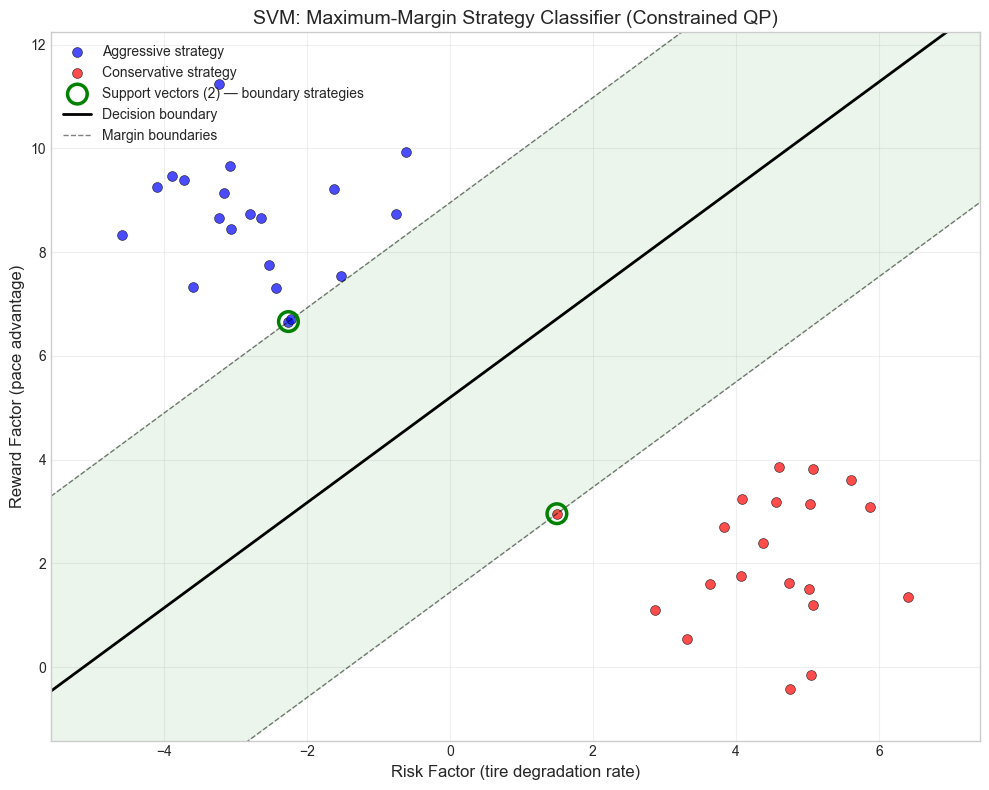

The SVM solves: min 1/2 ||w||^2 subject to y_i(w.x_i + b) >= 1
This is a quadratic program (QP) — convex with linear constraints.
The support vectors are the strategies with active constraints (on the margin).
Just like F1: only the regulations you're pushing against actually matter.


In [16]:
# Visualize the SVM solution with margin and support vectors
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data points — aggressive vs conservative strategies
for cls, color, label in [(-1, 'blue', 'Aggressive strategy'), (1, 'red', 'Conservative strategy')]:
    mask = y_train == cls
    ax.scatter(X_train[mask, 0], X_train[mask, 1], c=color, s=50,
               edgecolors='k', linewidth=0.5, label=label, alpha=0.7)

# Plot support vectors (the critical boundary strategies)
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200,
           facecolors='none', edgecolors='green', linewidths=2.5,
           label=f'Support vectors ({n_support}) — boundary strategies', zorder=5)

# Plot decision boundary and margins
x_boundary = np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 200)

# Decision boundary: w[0]*x + w[1]*y + b = 0
y_boundary = -(w[0] * x_boundary + b) / w[1]
y_margin_pos = -(w[0] * x_boundary + b - 1) / w[1]
y_margin_neg = -(w[0] * x_boundary + b + 1) / w[1]

ax.plot(x_boundary, y_boundary, 'k-', linewidth=2, label='Decision boundary')
ax.plot(x_boundary, y_margin_pos, 'k--', linewidth=1, alpha=0.5, label='Margin boundaries')
ax.plot(x_boundary, y_margin_neg, 'k--', linewidth=1, alpha=0.5)
ax.fill_between(x_boundary, y_margin_neg, y_margin_pos, alpha=0.08, color='green')

ax.set_xlabel('Risk Factor (tire degradation rate)', fontsize=12)
ax.set_ylabel('Reward Factor (pace advantage)', fontsize=12)
ax.set_title('SVM: Maximum-Margin Strategy Classifier (Constrained QP)', fontsize=14)
ax.legend(fontsize=10)
ax.set_xlim(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1)
ax.set_ylim(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The SVM solves: min 1/2 ||w||^2 subject to y_i(w.x_i + b) >= 1")
print("This is a quadratic program (QP) — convex with linear constraints.")
print("The support vectors are the strategies with active constraints (on the margin).")
print("Just like F1: only the regulations you're pushing against actually matter.")

/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/3112395695.py:64: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_5834/3112395695.py:64: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


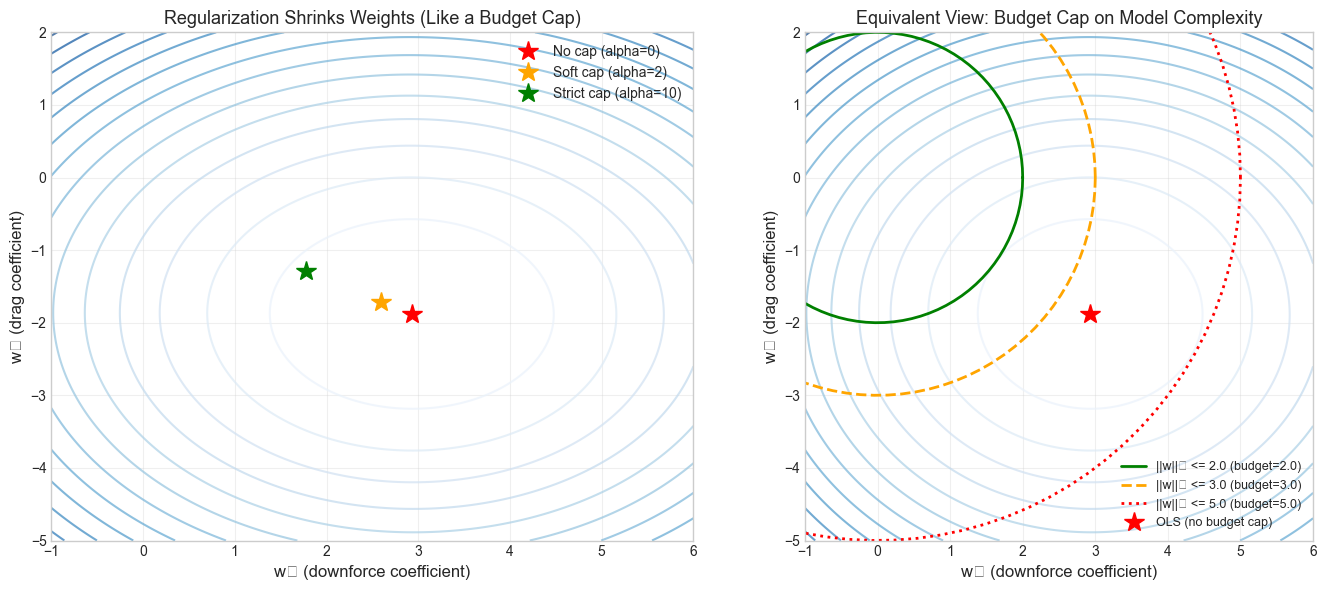

Left: Adding alpha*||w||^2 to the loss shrinks weights toward zero.
  Like a budget cap that penalizes excessive development spending.
Right: Equivalent to constraining ||w||_2 <= t (Lagrangian duality).
  Like a hard budget cap: you cannot exceed the limit, period.

This equivalence is Lagrangian duality in action:
  Penalized form: min L(w) + alpha*R(w)    [cost overrun penalty]
  Constrained form: min L(w) s.t. R(w) <= t [hard budget cap]
  The multiplier alpha and the budget t are dual to each other.


In [17]:
# Demonstrate: Regularization as a constraint
# F1 framing: budget cap as a constraint on development spending
# Ridge regression: min ||Xw - y||^2 + alpha * ||w||^2
# Equivalent to: min ||Xw - y||^2 subject to ||w||^2 <= t (budget cap)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create a simple telemetry prediction problem
np.random.seed(42)
w_true = np.array([3, -2])  # true relationship: speed depends on downforce and drag
X_reg = np.random.randn(20, 2)
y_reg = X_reg @ w_true + 0.5 * np.random.randn(20)

# Compute loss surface
w1_range = np.linspace(-1, 6, 200)
w2_range = np.linspace(-5, 2, 200)
W1, W2 = np.meshgrid(w1_range, w2_range)

Loss = np.zeros_like(W1)
for i in range(len(w1_range)):
    for j in range(len(w2_range)):
        w_test = np.array([W1[j, i], W2[j, i]])
        Loss[j, i] = np.sum((X_reg @ w_test - y_reg)**2) / len(y_reg)

# Left: Regularization view (penalized objective — "cost of complexity")
ax = axes[0]
ax.contour(W1, W2, Loss, levels=15, cmap='Blues', alpha=0.7)

# Show effect of different regularization strengths (budget caps)
for alpha, color, name in [(0, 'red', 'No cap (alpha=0)'), (2, 'orange', 'Soft cap (alpha=2)'),
                            (10, 'green', 'Strict cap (alpha=10)')]:
    w_ridge = np.linalg.solve(X_reg.T @ X_reg + alpha * np.eye(2), X_reg.T @ y_reg)
    ax.plot(w_ridge[0], w_ridge[1], '*', color=color, markersize=15, label=name, zorder=5)

ax.set_xlabel('w₁ (downforce coefficient)', fontsize=12)
ax.set_ylabel('w₂ (drag coefficient)', fontsize=12)
ax.set_title('Regularization Shrinks Weights (Like a Budget Cap)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Constraint view (norm ball — "budget limit")
ax = axes[1]
ax.contour(W1, W2, Loss, levels=15, cmap='Blues', alpha=0.7)

# L2 constraint ball (budget cap circles)
theta = np.linspace(0, 2*np.pi, 100)
for radius, color, ls in [(2.0, 'green', '-'), (3.0, 'orange', '--'), (5.0, 'red', ':')]:
    ax.plot(radius*np.cos(theta), radius*np.sin(theta), color=color, linewidth=2,
            linestyle=ls, label=f'||w||₂ <= {radius} (budget={radius})')

# OLS solution (no constraint — unlimited budget)
w_ols = np.linalg.solve(X_reg.T @ X_reg, X_reg.T @ y_reg)
ax.plot(w_ols[0], w_ols[1], 'r*', markersize=15, label='OLS (no budget cap)', zorder=5)

ax.set_xlabel('w₁ (downforce coefficient)', fontsize=12)
ax.set_ylabel('w₂ (drag coefficient)', fontsize=12)
ax.set_title('Equivalent View: Budget Cap on Model Complexity', fontsize=13)
ax.legend(fontsize=9)
ax.set_aspect('equal')
ax.set_xlim(-1, 6)
ax.set_ylim(-5, 2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Left: Adding alpha*||w||^2 to the loss shrinks weights toward zero.")
print("  Like a budget cap that penalizes excessive development spending.")
print("Right: Equivalent to constraining ||w||_2 <= t (Lagrangian duality).")
print("  Like a hard budget cap: you cannot exceed the limit, period.")
print("\nThis equivalence is Lagrangian duality in action:")
print("  Penalized form: min L(w) + alpha*R(w)    [cost overrun penalty]")
print("  Constrained form: min L(w) s.t. R(w) <= t [hard budget cap]")
print("  The multiplier alpha and the budget t are dual to each other.")

### Why This Matters in Machine Learning

| Optimization Concept | ML Application | How It's Used | F1 Parallel |
|----------------------|----------------|---------------|-------------|
| **Objective function** | Loss function | Measures how wrong the model is | Lap time (lower is better) |
| **Constraints** | Regularization, fairness constraints | Limits model complexity or enforces properties | FIA regulations (budget cap, weight, fuel flow) |
| **Feasible region** | Weight space satisfying constraints | Set of allowed model parameters | All legal car designs |
| **Convexity** | Guarantees on convergence | Convex losses guarantee finding the best model | Single-parameter setup: one sweet spot |
| **Lagrange multipliers** | SVM dual, regularization theory | Enable kernel trick, explain regularization | Shadow price of each regulation |
| **KKT conditions** | Support vectors, active constraints | Identify which data points matter | Which regulations actually constrain the car |
| **Duality** | SVM formulation, ELBO in VAEs | Provides alternative problem views | Team vs driver perspective |
| **Linear programming** | Network flow, assignment, scheduling | Combinatorial ML problems | Pit stop timing and tire allocation |

---

## Exercises

### Exercise 1: Formulate and Solve a Race Strategy LP

An F1 team is planning a 2-stop race and must decide how to allocate resources across two development areas:
- Each unit of **aero development** costs 3 wind tunnel hours and 1 CFD session, and gains 8 points of downforce.
- Each unit of **engine mapping** costs 1 dyno hour and 2 CFD sessions, and gains 5 horsepower.
- The team has 12 wind tunnel/dyno hours and 8 CFD sessions available this week.

**Task:** Formulate this as an LP and solve it using `scipy.optimize.linprog`. How many units of aero development and engine mapping should the team pursue to maximize total performance gain?

In [18]:
# EXERCISE 1: Solve the F1 development resource LP
def solve_development_lp():
    """
    Formulate and solve the F1 development resource LP.
    
    Returns:
        Tuple of (aero_units, engine_units, max_performance)
    """
    # TODO: Implement this!
    # Hint: linprog MINIMIZES, so negate the objective for maximization.
    # Hint: c = [-8, -5] for the negated performance objective
    # Hint: A_ub represents [wind_tunnel_constraint, cfd_constraint]
    
    pass  # Replace with your solution

# Test
result = solve_development_lp()
if result is not None:
    aero_units, engine_units, max_performance = result
    print(f"Aero development units: {aero_units:.2f}")
    print(f"Engine mapping units: {engine_units:.2f}")
    print(f"Maximum performance gain: {max_performance:.2f}")
    
    expected_performance = 34.40
    print(f"\nExpected performance: {expected_performance:.2f}")
    print(f"Correct: {np.isclose(max_performance, expected_performance, atol=0.1)}")

### Exercise 2: Verify Convexity

Write a function that numerically checks whether a 1D function is convex over a given interval by testing the secant line condition at random points. Think of it as checking whether a setup parameter's performance curve has a single "sweet spot" (convex) or multiple local optima (non-convex).

In [19]:
# EXERCISE 2: Check convexity numerically
def is_convex(f, x_min, x_max, n_tests=1000):
    """
    Numerically check if a function is convex over [x_min, x_max].
    
    A function is convex if for all x, y in the interval and lambda in [0,1]:
        f(lambda*x + (1-lambda)*y) <= lambda*f(x) + (1-lambda)*f(y)
    
    In F1 terms: does interpolating between two setup values always give
    a lap time that's no worse than the weighted average? If yes, it's convex
    (one sweet spot). If no, there might be multiple local optima.
    
    Args:
        f: Function to test (e.g., lap time as a function of wing angle)
        x_min, x_max: Interval endpoints
        n_tests: Number of random tests
    
    Returns:
        True if all tests pass (function appears convex), False otherwise
    """
    # TODO: Implement this!
    # Hint: For each test, pick random x, y in [x_min, x_max]
    #       and random lambda in [0, 1], then check the inequality.
    
    pass  # Replace with your solution

# Test with known functions (F1-themed descriptions)
f_quadratic = lambda x: x**2          # convex — like spring stiffness vs lap time
f_absolute = lambda x: np.abs(x)       # convex — like tire wear vs offset from optimal pressure
f_sine = lambda x: np.sin(x)           # NOT convex — like full aero map with multiple optima
f_exp = lambda x: np.exp(x)            # convex — like exponential degradation

if is_convex is not None and is_convex(f_quadratic, -5, 5) is not None:
    print(f"x² (spring stiffness): convex = {is_convex(f_quadratic, -5, 5)}")
    print(f"|x| (tire pressure offset): convex = {is_convex(f_absolute, -5, 5)}")
    print(f"sin(x) (aero map) on [-pi,pi]: convex = {is_convex(f_sine, -np.pi, np.pi)}")
    print(f"exp(x) (degradation curve): convex = {is_convex(f_exp, -5, 5)}")
    print(f"\nExpected: True, True, False, True")

### Exercise 3: Lagrange Multipliers by Hand (with Verification)

An F1 team wants to minimize their combined aero drag and engine weight penalty:

$$\min_{x,y} \; x^2 + 2y^2 \quad \text{subject to} \quad x + y = 3$$

where $x$ represents the aero investment and $y$ represents the engine investment, and they must allocate exactly 3 units of total development budget.

**Steps:**
1. Write the Lagrangian: $\mathcal{L} = x^2 + 2y^2 + \lambda(x + y - 3)$
2. Set partial derivatives to zero and solve
3. Verify numerically
4. Interpret the Lagrange multiplier: how much would relaxing the budget by 1 unit improve performance?

In [20]:
# EXERCISE 3: Lagrange multipliers for F1 budget allocation
def solve_budget_allocation():
    """
    Solve: min x^2 + 2y^2 subject to x + y = 3
    
    F1 interpretation:
    - x = aero investment, y = engine investment
    - x^2 + 2y^2 = combined performance penalty (engine is more expensive per unit)
    - x + y = 3: total budget constraint
    
    Analytical steps:
    L = x^2 + 2y^2 + lambda*(x + y - 3)
    dL/dx = 2x + lambda = 0      -> x = -lambda/2
    dL/dy = 4y + lambda = 0      -> y = -lambda/4
    dL/dlambda = x + y - 3 = 0   -> -lambda/2 - lambda/4 = 3
                                  -> -3*lambda/4 = 3
                                  -> lambda = -4
    So: x = 2 (aero), y = 1 (engine), lambda = -4
    
    Returns:
        Tuple of (aero_opt, engine_opt, lambda_opt, penalty_opt)
    """
    # TODO: Return the analytical solution
    # Hint: Follow the steps in the docstring above
    
    pass  # Replace with your solution

# Numerical verification
result_num = minimize(
    lambda xy: xy[0]**2 + 2*xy[1]**2,
    x0=[0, 0],
    method='SLSQP',
    constraints={'type': 'eq', 'fun': lambda xy: xy[0] + xy[1] - 3}
)

print("=== Numerical Solution ===")
print(f"Aero investment = {result_num.x[0]:.4f}, Engine investment = {result_num.x[1]:.4f}")
print(f"Combined penalty = {result_num.fun:.4f}")

if solve_budget_allocation is not None and solve_budget_allocation() is not None:
    aero_opt, engine_opt, lambda_opt, penalty_opt = solve_budget_allocation()
    print(f"\n=== Your Analytical Solution ===")
    print(f"Aero = {aero_opt}, Engine = {engine_opt}, lambda = {lambda_opt}")
    print(f"Combined penalty = {penalty_opt}")
    print(f"\nMatch: {np.allclose([aero_opt, engine_opt], result_num.x, atol=0.01)}")
    print(f"Expected: aero=2, engine=1, lambda=-4, penalty=6")
    print(f"\nInterpretation: lambda = -4 means each additional unit of budget")
    print(f"would reduce the penalty by ~4 units. Valuable intel for the team principal!")

=== Numerical Solution ===
Aero investment = 2.0000, Engine investment = 1.0000
Combined penalty = 6.0000


### Exercise 4: Car Setup Landscape Explorer

Write a function that takes a 2D objective function (like lap time as a function of two setup parameters) and visualizes:
1. The contour plot (setup performance landscape)
2. The gradient descent path from a given starting setup
3. The final (approximate) optimal setup

In [21]:
# EXERCISE 4: Build a car setup landscape explorer
def explore_setup_landscape(f, grad_f, x0, lr=0.01, n_steps=200,
                            x_range=(-5, 5), y_range=(-5, 5)):
    """
    Visualize a 2D setup optimization landscape with gradient descent path.
    
    Think of this as an engineer exploring the setup space: starting with an
    initial configuration and iteratively tweaking wing angle and ride height
    to find the fastest setup.
    
    Args:
        f: Objective function f(wing, ride) -> lap_time_penalty
        grad_f: Gradient function grad_f(wing, ride) -> (df/d_wing, df/d_ride)
        x0: Starting setup [wing_angle, ride_height]
        lr: Learning rate (size of each setup adjustment)
        n_steps: Number of setup iterations
        x_range: (min, max) for wing angle axis
        y_range: (min, max) for ride height axis
    """
    # TODO: Implement this!
    # Step 1: Create meshgrid and compute Z = f(X, Y)
    # Step 2: Run gradient descent, storing the setup path
    # Step 3: Plot contours + path + start/end markers
    # Hint: Use ax.contourf for filled contours and ax.plot for the path
    
    pass  # Replace with your solution

# Test with Rosenbrock function (a classic test — like a tricky setup landscape)
# The Rosenbrock "valley" is like a narrow setup window: easy to find the valley,
# hard to find the exact bottom.
f_rosen = lambda x, y: (1 - x)**2 + 100*(y - x**2)**2
grad_rosen = lambda x, y: (
    -2*(1 - x) - 400*x*(y - x**2),
    200*(y - x**2)
)

print("Implement explore_setup_landscape() to visualize gradient descent on the")
print("Rosenbrock function (a notoriously tricky setup landscape).")
print("The optimal setup is at (1, 1) — but the narrow valley makes it hard to find.")
print("Try different learning rates and starting setups!")

# Uncomment after implementing:
# explore_setup_landscape(f_rosen, grad_rosen, x0=[-1, -1], lr=0.001, n_steps=5000,
#                         x_range=(-2, 2), y_range=(-1, 3))

Implement explore_setup_landscape() to visualize gradient descent on the
Rosenbrock function (a notoriously tricky setup landscape).
The optimal setup is at (1, 1) — but the narrow valley makes it hard to find.
Try different learning rates and starting setups!


---

## Summary

### Key Concepts

| Concept | Definition | F1 Parallel |
|---------|-----------|-------------|
| **Optimization** | Finding the best solution from a feasible set (objective + variables + constraints) | Finding the fastest legal race strategy |
| **Linear programming** | Optimizing a linear objective subject to linear constraints; solution at a vertex | Tire/fuel allocation under FIA rules; best strategy is at a regulation boundary |
| **Simplex method** | Solve LPs by hopping between adjacent vertices, always improving | Strategist testing neighboring pit lap options until no tweak helps |
| **Duality** | Every LP has an alternative (dual) formulation; strong duality means same optimal value | Team principal's view vs driver's view of the same resource allocation |
| **Convexity** | Key property ensuring local minima are global minima; gradient descent works | Single-parameter setup (one sweet spot) vs full car design (many local optima) |
| **Lagrange multipliers** | Solve equality-constrained problems via gradient alignment | Shadow price of FIA regulations ("seconds per kg of weight relief") |
| **KKT conditions** | Generalize Lagrange multipliers to inequality constraints; complementary slackness identifies active constraints | Only the regulations you are pushing against actually shape the car |
| **ML is optimization** | SVMs solve QPs, regularization is dual to constraints, losses are designed to be convex | F1 engineering is constrained optimization at every level |

### Connection to Machine Learning

| Concept from this Notebook | Where You Will See It in ML | F1 Parallel |
|---------------------------|-----------------------------|-------------|
| Objective function | Every loss function (MSE, cross-entropy, hinge) | Lap time (the ultimate objective) |
| Feasible region / constraints | Regularization ($\ell_1$, $\ell_2$), fairness constraints | FIA regulations bounding the design space |
| Convexity | Guarantees for logistic regression, SVM, LASSO | Spring stiffness has one optimal; car design does not |
| Non-convexity | Neural network training challenges | Why teams sometimes need a radical concept reset |
| Lagrange multipliers / KKT | SVM support vectors, dual formulations | Shadow price of each regulation on lap time |
| Duality | Kernel trick in SVMs, ELBO in variational inference | Same allocation problem from team vs driver perspective |
| Linear programming | Resource allocation, network optimization | Pit stop timing, tire compound selection, budget split |
| Gradient descent (preview) | The topic of the next notebook! | How engineers iteratively refine a setup |

### Checklist

Before moving on, make sure you can:

- [ ] Define an optimization problem with objective, variables, and constraints
- [ ] Formulate an LP in standard form and solve it with `linprog`
- [ ] Explain why LP solutions occur at vertices (and why the best F1 strategy pushes regulation limits)
- [ ] Describe the Simplex method's vertex-hopping strategy
- [ ] State weak and strong duality theorems
- [ ] Distinguish convex from non-convex functions (setup tuning vs car design)
- [ ] Explain why convexity guarantees a global optimum
- [ ] Set up and solve a Lagrangian for equality constraints
- [ ] State the four KKT conditions and explain complementary slackness
- [ ] Frame an SVM as a constrained optimization problem
- [ ] Explain regularization as a Lagrangian constraint (the budget cap analogy)

---

## Next Steps

Continue to **Part 3.3: Gradient-Based Optimization** where we will cover:
- Gradient descent and its variants (SGD, momentum, Adam)
- Learning rate schedules and convergence theory
- Automatic differentiation
- How these methods actually train neural networks

**Looking ahead:** Now that you understand *what* optimization is and *when* it works well (convexity), the next notebook focuses on *how* we actually solve optimization problems in practice — with gradients. Every deep learning training loop is gradient descent applied to a (usually non-convex) loss function. And just like an F1 engineer tweaking setup parameters one session at a time, gradient descent iteratively moves toward the optimum — one step at a time, guided by the slope of the landscape.